In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 49.1 MB/s eta 0:00:00


In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def create_portfolio(stock_data, index_data, portfolio_size=15, max_iterations=100000):
    I = np.array(stock_data.columns)  # Conjunto de ativos disponíveis
    T = range(len(stock_data))  # Número de períodos
    r = {(t, i): stock_data.iloc[t][i] for t in T for i in I} # Retornos individuais dos ativos
    R =  np.array(index_data) # Retornos do índice
    k = portfolio_size

    model = gp.Model("TrackingPortfolio")
    w = model.addVars(I, lb=0, ub=1, name="w")  # Pesos dos ativos
    z = model.addVars(I, vtype=GRB.BINARY, name="z")  # Seleção de ativos

    model.setObjective(
        (1 / len(T)) * gp.quicksum(
            (gp.quicksum(w[i] * r[t, i] for i in I) - R[t]) ** 2 for t in T
        ),
        GRB.MINIMIZE
    )

    model.addConstr(gp.quicksum(w[i] for i in I) == 1, "SomaPesos")  # Soma dos pesos deve ser 1
    model.addConstrs((w[i] <= z[i] for i in I), "VinculoPesos")      # Pesos vinculados a z
    model.addConstr(gp.quicksum(z[i] for i in I) == k, "MaxAtivos")  # Máximo de K ativos

    model.setParam(GRB.Param.IterationLimit, max_iterations)  # Teste inicial com 100.000 iterações

    model.optimize()

    print("\nAções da carteira:")
    for i in I:
        if z[i].x:
            print(f"Ativo {i}: Peso = {w[i].x:.4f}")

    print("\nAções não adicionadas na carteira:")
    for i in I:
        if not z[i].x:
            print(f"Ativo {i}: Peso = {w[i].x:.4f}")

    portfolio_weights = {i: w[i].x for i in I if z[i].x}

    return portfolio_weights

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

def build_dataset(index_ticker, stock_tickers, start_date, end_date, max_missing_days=30):
    """
    Builds a dataset by downloading, cleaning, and calculating returns for a list of stock tickers.

    :param index_ticker: Ticker symbol for the index to include in the dataset
    :param start_date: Starting date for the historical data download
    :param end_date: Ending date for the historical data download
    :param max_missing_days: Maximum allowed consecutive days of missing data per stock
    :return: DataFrame with historical stock data and returns
    """
    # Download data
    data = download_data(index_ticker, stock_tickers, start_date, end_date)
    data = clean_data(data, max_missing_days)

    # Calculate returns and save
    returns = calculate_returns(data)
    returns_filename = f"stock_returns_{index_ticker}_{start_date.strftime('%Y-%m-%d')}_to_{end_date.strftime('%Y-%m-%d')}.csv"
    returns.to_csv(returns_filename)
    print(f"Stock returns saved to {returns_filename}")

    # Generate shares outstanding and calculate weights
    #shares_df = generate_shares_outstanding(stock_tickers)
    #weights = calculate_weights(data, shares_df, index_ticker)
    #weights_filename = f"stock_weights_{index_ticker}_{start_date.strftime('%Y-%m-%d')}_to_{end_date.strftime('%Y-%m-%d')}.csv"
    #weights.to_csv(weights_filename)
    #print(f"Stock weights saved to {weights_filename}")

    return data, returns

def download_data(index_ticker, stock_tickers, start_date, end_date):
    """
    Downloads historical adjusted close prices for an index and a list of stocks.

    :param index_ticker: Ticker symbol for the index
    :param start_date: Starting date for data download
    :param end_date: Ending date for data download
    :return: DataFrame containing the adjusted close prices for all tickers
    """
    try:
        # Combine the index and stock tickers into a single list
        all_tickers = [index_ticker] + stock_tickers
        data: pd.DataFrame = pd.DataFrame()
        data = yf.download(all_tickers, start=start_date, end=end_date)['Adj Close']
        print("Data downloaded successfully.")
        return data
    except Exception as e:
        print(f"An error occurred on data download: {e}")
        return None

def clean_data(data, max_missing_days=30):
    """
    Cleans stock data by removing stocks with prolonged missing data and interpolating gaps.

    :param data: DataFrame with stock price data
    :param max_missing_days: Maximum allowed consecutive missing days per stock
    :return: Cleaned DataFrame with interpolated data and stocks with prolonged gaps removed
    """
    try:
        data = remove_stocks_with_prolonged_missing_data(data, days_limit=max_missing_days)
        # Interpolate remaining missing values linearly using adjacent data points
        data = data.interpolate(method='linear')

        print("Data cleaned successfully.")
        return data
    except Exception as e:
        print(f"An error occurred on clean data: {e}")
        return None

def remove_stocks_with_prolonged_missing_data(data, days_limit=30):
    """
    Removes stocks with consecutive missing data days exceeding the specified limit.

    :param data: DataFrame with stock price data
    :param days_limit: Maximum allowed consecutive missing days per stock
    :return: DataFrame with only stocks that meet the missing data criteria
    """
    def check_consecutive_nans(column):
        # Create a binary series (1 for NaN, 0 for data) to identify NaN sequences
        nan_seq = column.isna().astype(int)
        # Calculate the longest consecutive sequence of NaNs
        max_nan_streak = nan_seq.groupby((nan_seq != nan_seq.shift()).cumsum()).transform('sum').max()

        return max_nan_streak >= days_limit

    # Select stocks that do not exceed the allowed limit of consecutive missing data days
    try:
        valid_columns = [col for col in data.columns if not check_consecutive_nans(data[col])]
        filtered_data = data[valid_columns]

        print(f"Removed stocks: {set(data.columns) - set(valid_columns)}")
        return filtered_data
    except Exception as e:
        print(f"An error occurred o remove stocks with consecutive missing data: {e}")
        return None

def calculate_returns(data):
    """
    Calculates daily returns for the given stock data.

    :param data: DataFrame with cleaned stock price data
    :return: DataFrame with daily returns for each stock
    """
    try:
        # Calculate the daily returns by percentage change in stock prices
        returns = data.pct_change()
        returns = returns.iloc[1:, :]

        return returns
    except Exception as e:
        print(f"An error occurred in calculate returns: {e}")
        return None

def generate_shares_outstanding(stock_tickers):
    """
    Generates a DataFrame containing the shares outstanding for a list of stock tickers.

    :param stock_tickers: List of stock tickers
    :return: DataFrame containing Ticker and Shares Outstanding
    """
    data = [
        {'Ticker': ticker, 'Shares Outstanding': yf.Ticker(ticker).info.get('sharesOutstanding')}
        for ticker in stock_tickers
        if yf.Ticker(ticker).info.get('sharesOutstanding') is not None
    ]

    # Cria um DataFrame diretamente a partir da lista
    return pd.DataFrame(data)

def calculate_weights(data, shares_df, index_ticker):
    """
    Calculates the weights of each stock in the index based on market capitalization.

    :param data: DataFrame with adjusted close prices
    :param shares_df: DataFrame containing shares outstanding for the stock tickers
    :param index_ticker: Ticker symbol of the index (to exclude it from the calculation)
    :return: DataFrame with weights for each stock
    """
    # Remove o índice do cálculo (se presente no DataFrame)
    data = data.drop(columns=[index_ticker])

    # Define o index do DataFrame de ações para alinhar com os preços
    shares_df = shares_df.set_index('Ticker')

    # Obtém os preços mais recentes
    latest_prices = data.iloc[-1]

    # Calcula a capitalização de mercado
    market_caps = latest_prices * shares_df['Shares Outstanding']

    # Calcula os pesos (capitalização de mercado individual / total)
    weights = market_caps / market_caps.sum()

    # Retorna os pesos em um DataFrame
    return pd.DataFrame(weights, columns=['Weight'])

In [4]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Define index and stock tickers
bvsp_index_ticker = '^BVSP'
bvsp_stock_tickers = [
  "ALOS3.SA", "ALPA4.SA", "ABEV3.SA", "ASAI3.SA", "AURE3.SA", "AZUL4.SA", "AZZA3.SA",
  "B3SA3.SA", "BBSE3.SA", "BBDC3.SA", "BBDC4.SA", "BRAP4.SA", "BBAS3.SA", "BRKM5.SA",
  "BRAV3.SA", "BRFS3.SA", "BPAC11.SA", "CXSE3.SA", "CRFB3.SA", "CCRO3.SA", "CMIG4.SA",
  "COGN3.SA", "CPLE6.SA", "CSAN3.SA", "CPFE3.SA", "CMIN3.SA", "CVCB3.SA", "CYRE3.SA",
  "ELET3.SA", "ELET6.SA", "EMBR3.SA", "ENGI11.SA", "ENEV3.SA", "EGIE3.SA", "EQTL3.SA",
  "EZTC3.SA", "FLRY3.SA", "GGBR4.SA", "GOAU4.SA", "NTCO3.SA", "HAPV3.SA", "HYPE3.SA",
  "IGTI11.SA", "IRBR3.SA", "ITSA4.SA", "ITUB4.SA", "JBSS3.SA", "KLBN11.SA", "RENT3.SA",
  "LREN3.SA", "LWSA3.SA", "MGLU3.SA", "MRFG3.SA", "BEEF3.SA", "MRVE3.SA", "MULT3.SA",
  "PCAR3.SA", "PETR3.SA", "PETR4.SA", "RECV3.SA", "PRIO3.SA", "PETZ3.SA", "RADL3.SA",
  "RAIZ4.SA", "RDOR3.SA", "RAIL3.SA", "SBSP3.SA", "SANB11.SA", "STBP3.SA", "SMTO3.SA",
  "CSNA3.SA", "SLCE3.SA", "SUZB3.SA", "TAEE11.SA", "VIVT3.SA", "TIMS3.SA", "TOTS3.SA",
  "TRPL4.SA", "UGPA3.SA", "USIM5.SA", "VALE3.SA", "VAMO3.SA", "VBBR3.SA", "VIVA3.SA",
  "WEGE3.SA", "YDUQ3.SA"
]

sp100_index_ticker = '^OEX'
sp100_stock_tickers = [
    'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN',
    'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'C', 'CAT',
    'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX',
    'DHR', 'DIS', 'DOW', 'DUK', 'EMR', 'EXC', 'F', 'FDX', 'GD', 'GE',
    'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ',
    'JPM', 'KHC', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT',
    'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE',
    'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX',
    'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH',
    'UNP', 'UPS', 'USB', 'V', 'VZ', 'WBA', 'WFC', 'WMT'
]

In [6]:
start_date_dataset = dt.datetime(2023, 1, 1, tzinfo=dt.timezone.utc)
end_date_dataset = dt.datetime(2024, 1, 1, tzinfo=dt.timezone.utc)
start_date_train = start_date_dataset
end_date_train = dt.datetime(2023, 6, 1, tzinfo=dt.timezone.utc)
start_date_test = end_date_train
end_date_test = end_date_dataset

In [7]:
def download(index_ticker, stock_tickers, start_date, end_date):
    values, data = build_dataset(index_ticker, stock_tickers, start_date, end_date)

    index_data = data[index_ticker]
    stocks_data = data.drop(columns=[index_ticker])

    index_values = values[index_ticker]
    stock_values = values.drop(columns=[index_ticker])

    return stocks_data, index_data, stock_values, index_values

In [8]:
# Build dataset from choosen tickers
x_sp100_data_train, y_sp100_data_train, x_sp100_values_train, y_sp100_values_train = download(sp100_index_ticker, sp100_stock_tickers, start_date_train, end_date_train)
x_bvsp_data_train, y_bvsp_data_train, x_bvsp_values_train, y_bvsp_values_train = download(bvsp_index_ticker, bvsp_stock_tickers, start_date_train, end_date_train)

x_sp100_data_test, y_sp100_data_test, x_sp100_values_test, y_sp100_values_test = download(sp100_index_ticker, sp100_stock_tickers, start_date_test, end_date_test)
x_bvsp_data_test, y_bvsp_data_test, x_bvsp_values_test, y_bvsp_values_test = download(bvsp_index_ticker, bvsp_stock_tickers, start_date_test, end_date_test)

[*********************100%***********************]  99 of 99 completed


Data downloaded successfully.
Removed stocks: set()
Data cleaned successfully.


[                       0%                       ]

Stock returns saved to stock_returns_^OEX_2023-01-01_to_2023-06-01.csv


[*********************100%***********************]  87 of 87 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRAV3.SA', 'ALOS3.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-01-01 00:00:00+00:00 -> 2023-06-01 00:00:00+00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1672531200, endDate = 1685577600")')


Data downloaded successfully.
Removed stocks: {'BRAV3.SA', 'ALOS3.SA'}
Data cleaned successfully.
Stock returns saved to stock_returns_^BVSP_2023-01-01_to_2023-06-01.csv


[*********************100%***********************]  99 of 99 completed


Data downloaded successfully.
Removed stocks: set()
Data cleaned successfully.


[                       0%                       ]

Stock returns saved to stock_returns_^OEX_2023-06-01_to_2024-01-01.csv


[*********************100%***********************]  87 of 87 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRAV3.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-06-01 00:00:00+00:00 -> 2024-01-01 00:00:00+00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1685577600, endDate = 1704067200")')


Data downloaded successfully.
Removed stocks: {'BRAV3.SA', 'ALOS3.SA'}
Data cleaned successfully.
Stock returns saved to stock_returns_^BVSP_2023-06-01_to_2024-01-01.csv


## Portfolio com 25

In [9]:
portfolio_sp100 = create_portfolio(x_sp100_data_train, y_sp100_data_train, portfolio_size=25, max_iterations=10000000)

Restricted license - for non-production use only - expires 2026-11-23
Set parameter IterationLimit to value 10000000
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
IterationLimit  10000000

Optimize a model with 100 rows, 196 columns and 392 nonzeros
Model fingerprint: 0xe3575adf
Model has 4851 quadratic objective terms
Variable types: 98 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 5e-04]
  QObjective range [2e-07, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 0.0001821
Presolve time: 0.01s
Presolved: 100 rows, 196 columns, 392 nonzeros
Presolved model has 4851 quadratic objective terms
Variable types: 98 continuous, 98 integer (98 binary)

In [10]:
portfolio_bvsp = create_portfolio(x_bvsp_data_train, y_bvsp_data_train, portfolio_size=25, max_iterations=10000000)

Set parameter IterationLimit to value 10000000
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
IterationLimit  10000000

Optimize a model with 86 rows, 168 columns and 336 nonzeros
Model fingerprint: 0xe34647eb
Model has 3570 quadratic objective terms
Variable types: 84 continuous, 84 integer (84 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 6e-04]
  QObjective range [2e-08, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 0.0003106
Presolve time: 0.00s
Presolved: 86 rows, 168 columns, 336 nonzeros
Presolved model has 3570 quadratic objective terms
Variable types: 84 continuous, 84 integer (84 binary)

Root relaxation: objective 7.596040e-07, 520 iterations, 0.01 seconds 

In [11]:
portfolio_bvsp_sorted = sorted(portfolio_bvsp.items(), key=lambda item: float(item[1]), reverse=True)

print("portfolio bvsp:")
for key, value in portfolio_bvsp_sorted:
    print(f"{key}: {float(value):.4f}")

print(f"\nportfolio bvsp length: {len(portfolio_bvsp)}")

portfolio bvsp:
VALE3.SA: 0.1682
PETR4.SA: 0.1119
ITUB4.SA: 0.0869
BPAC11.SA: 0.0664
TRPL4.SA: 0.0510
ELET3.SA: 0.0488
RAIL3.SA: 0.0483
ABEV3.SA: 0.0454
BBDC3.SA: 0.0442
EQTL3.SA: 0.0418
GGBR4.SA: 0.0357
TAEE11.SA: 0.0347
BBAS3.SA: 0.0316
WEGE3.SA: 0.0290
SUZB3.SA: 0.0280
LREN3.SA: 0.0244
ASAI3.SA: 0.0177
PRIO3.SA: 0.0169
RDOR3.SA: 0.0121
HAPV3.SA: 0.0111
YDUQ3.SA: 0.0105
VAMO3.SA: 0.0103
CVCB3.SA: 0.0095
BRFS3.SA: 0.0092
MGLU3.SA: 0.0065

portfolio bvsp length: 25


In [12]:
portfolio_sp100_sorted = sorted(portfolio_sp100.items(), key=lambda item: float(item[1]), reverse=True)

print("portfolio sp100:")
for key, value in portfolio_sp100_sorted:
    print(f"{key}: {float(value):.4f}")

print(f"\nportfolio bvsp length: {len(portfolio_sp100)}")

portfolio sp100:
AAPL: 0.1291
MSFT: 0.0978
VZ: 0.0685
GOOG: 0.0625
RTX: 0.0513
AMZN: 0.0510
BK: 0.0466
LLY: 0.0463
BAC: 0.0397
COST: 0.0365
ABBV: 0.0328
NVDA: 0.0315
TMO: 0.0308
SPG: 0.0303
ACN: 0.0288
JNJ: 0.0271
MMM: 0.0270
SBUX: 0.0261
AVGO: 0.0252
CSCO: 0.0222
DIS: 0.0210
GILD: 0.0201
CVX: 0.0199
JPM: 0.0164
AMD: 0.0118

portfolio bvsp length: 25


In [14]:
def plot_portfolio_variance(portfolio, stocks_data, index_data, start_date, end_date, index_name):
    a = [key for key in portfolio if key in stocks_data.columns]
    portfolio_data = stocks_data[a]

    weights = pd.Series(portfolio).reindex(a).values

    portfolio_data_filtered = (portfolio_data * weights).sum(axis=1).loc[start_date:end_date]

    index_data_filtered = index_data.loc[start_date:end_date]

    start_date_str = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    end_date_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')

    fig = plt.figure(figsize=(15, 8), facecolor='black')
    eixo = fig.add_axes([0, 0, 1, 1], facecolor='black')

    eixo.plot(index_data_filtered.index, index_data_filtered, color='red', linestyle='-', linewidth=3, label=index_name)
    eixo.plot(portfolio_data_filtered.index, portfolio_data_filtered, color='gold', linewidth=1, label="Portfolio")

    eixo.set_title(f"Portfolio 25 stocks {index_name}: {start_date_str} to {end_date_str}", fontsize=25, pad=20, color='white')
    eixo.legend(title="Indicador", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')
    eixo.set_ylabel('Variance', fontsize=20, color='white')
    eixo.set_xlabel('Data', fontsize=20, color='white')
    eixo.grid(color='gray', linestyle='--')

In [15]:
def plot_portfolio(portfolio, stocks_data, index_data, start_date, end_date, index_name):
    a = [key for key in portfolio if key in stocks_data.columns]
    portfolio_data = stocks_data[a]

    weights = pd.Series(portfolio).reindex(a).values

    scaler = MinMaxScaler()

    portfolio_data_filtered = (portfolio_data * weights).sum(axis=1).loc[start_date:end_date]
    portfolio_data_normalized = scaler.fit_transform(portfolio_data_filtered.values.reshape(-1, 1))

    index_data_filtered = index_data.loc[start_date:end_date]
    index_data_normalized = scaler.fit_transform(index_data_filtered.values.reshape(-1, 1))

    start_date_str = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    end_date_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')

    fig = plt.figure(figsize=(15, 8), facecolor='black')
    eixo = fig.add_axes([0, 0, 1, 1], facecolor='black')

    eixo.plot(index_data_filtered.index, index_data_normalized, color='red', linestyle='-', linewidth=3, label=index_name)
    eixo.plot(portfolio_data_filtered.index, portfolio_data_normalized, color='gold', linestyle='--', linewidth= 3, label="Portfolio")

    eixo.set_title(f"Portfolio 25 stocks {index_name}: {start_date_str} to {end_date_str}", fontsize=25, pad=20, color='white')
    eixo.legend(title="Indicador", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')
    eixo.set_ylabel('Normalized Value', fontsize=20, color='white')
    eixo.set_xlabel('Data', fontsize=20, color='white')
    eixo.tick_params(colors='white')
    eixo.grid(color='gray', linestyle='--')

## Values

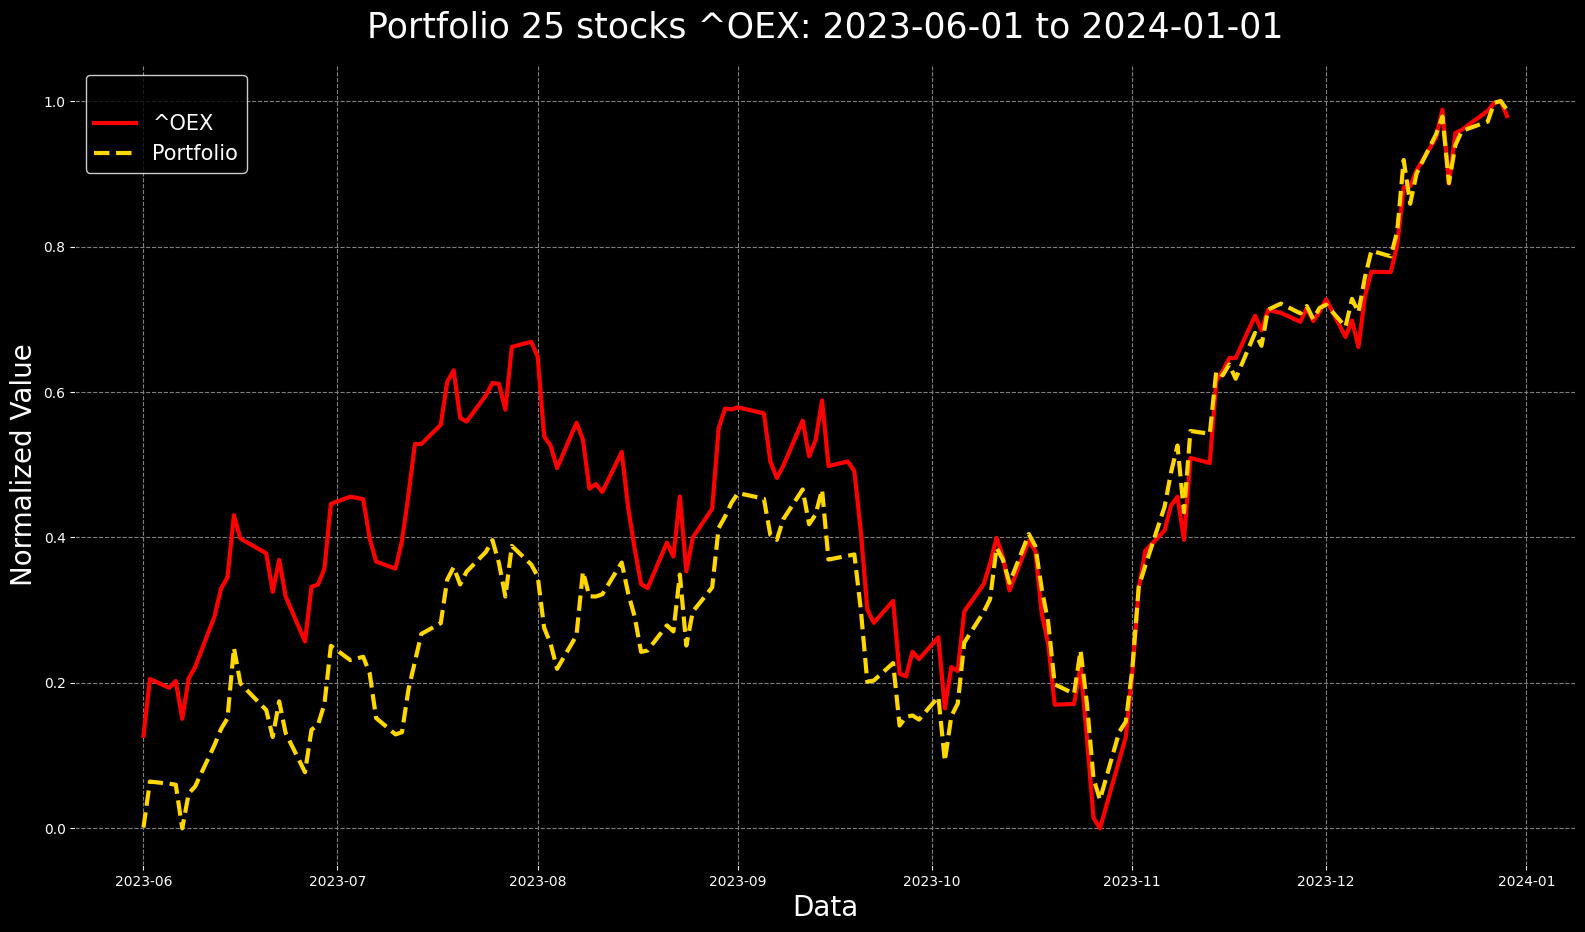

In [16]:
plot_portfolio(portfolio_sp100, x_sp100_values_test, y_sp100_values_test, start_date_test, end_date_test, sp100_index_ticker)

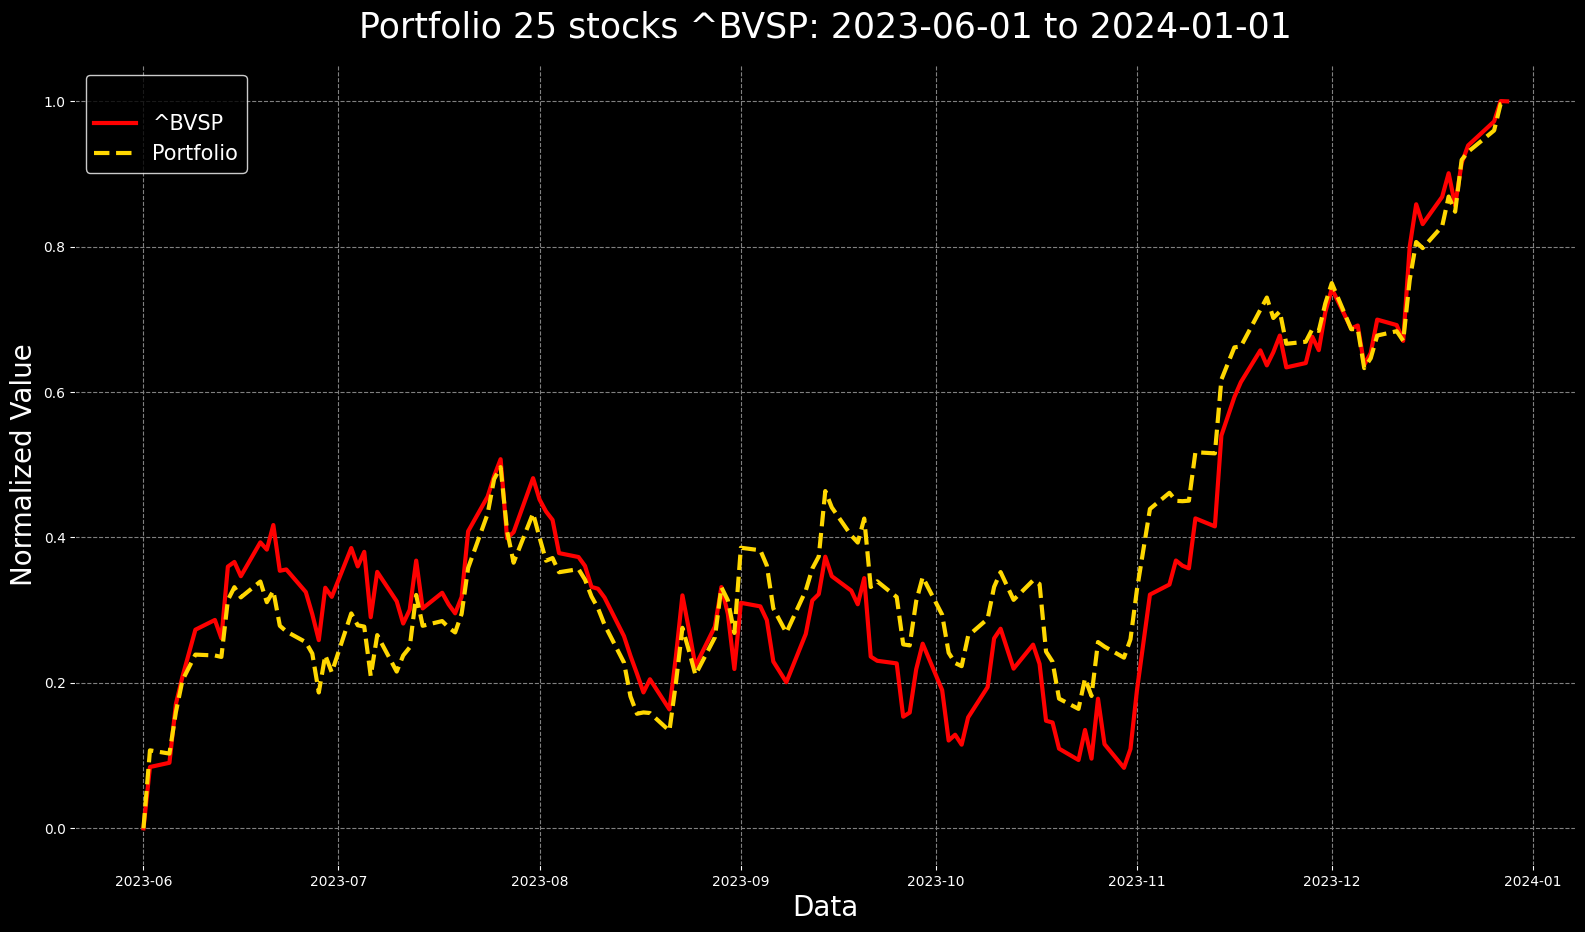

In [17]:
plot_portfolio(portfolio_bvsp, x_bvsp_values_test, y_bvsp_values_test, start_date_test, end_date_test, bvsp_index_ticker)

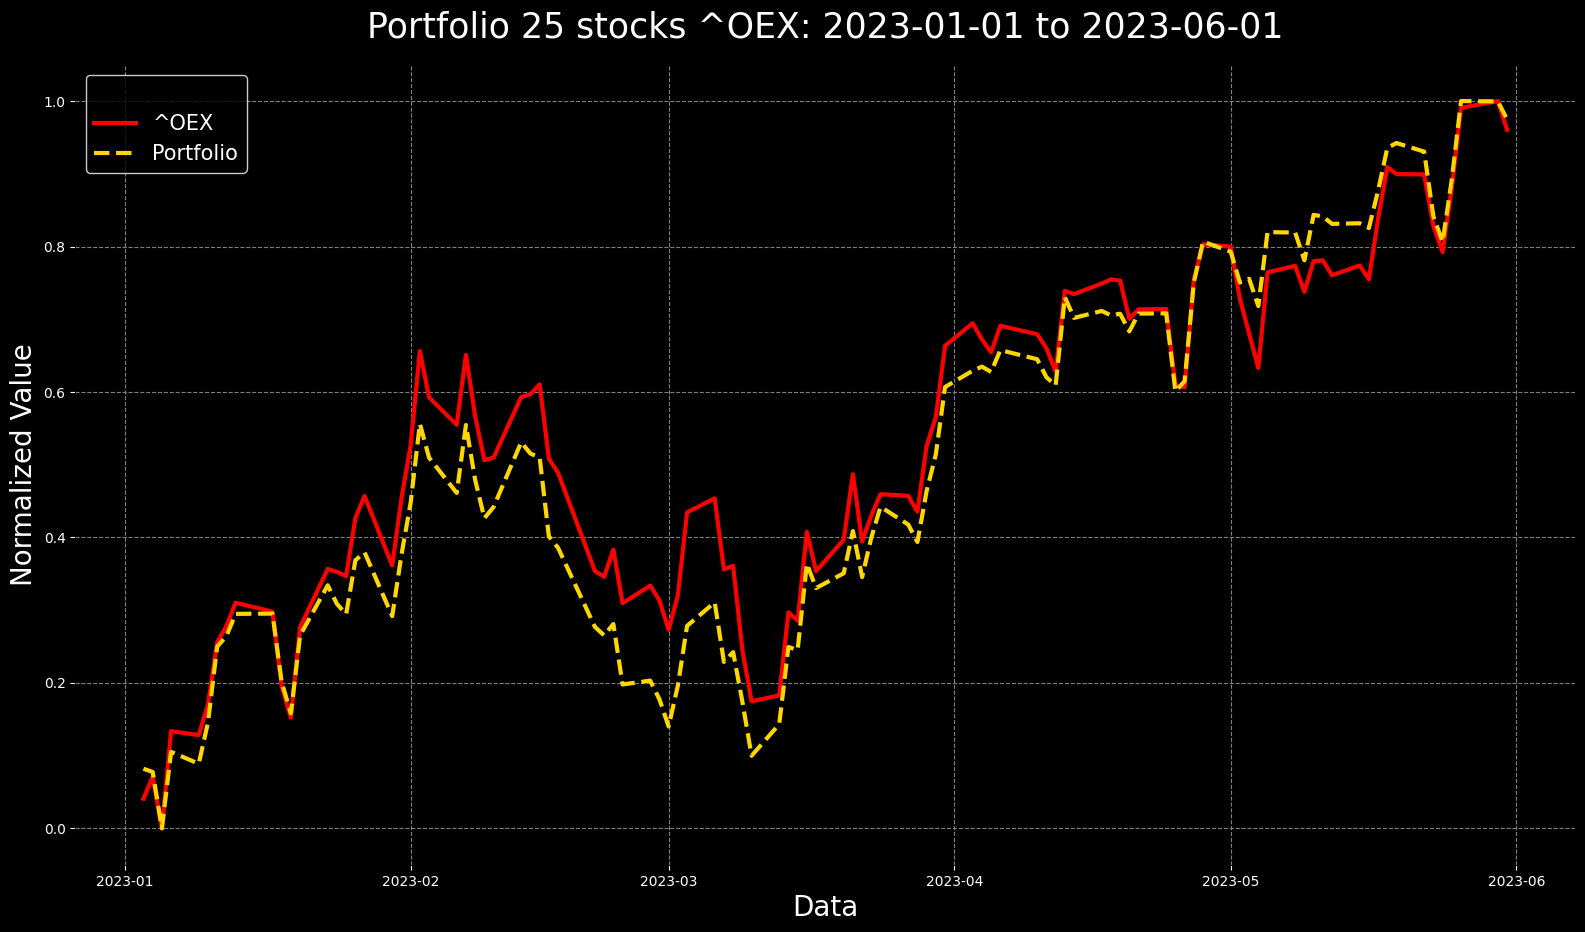

In [18]:
plot_portfolio(portfolio_sp100, x_sp100_values_train, y_sp100_values_train, start_date_train, end_date_train, sp100_index_ticker)

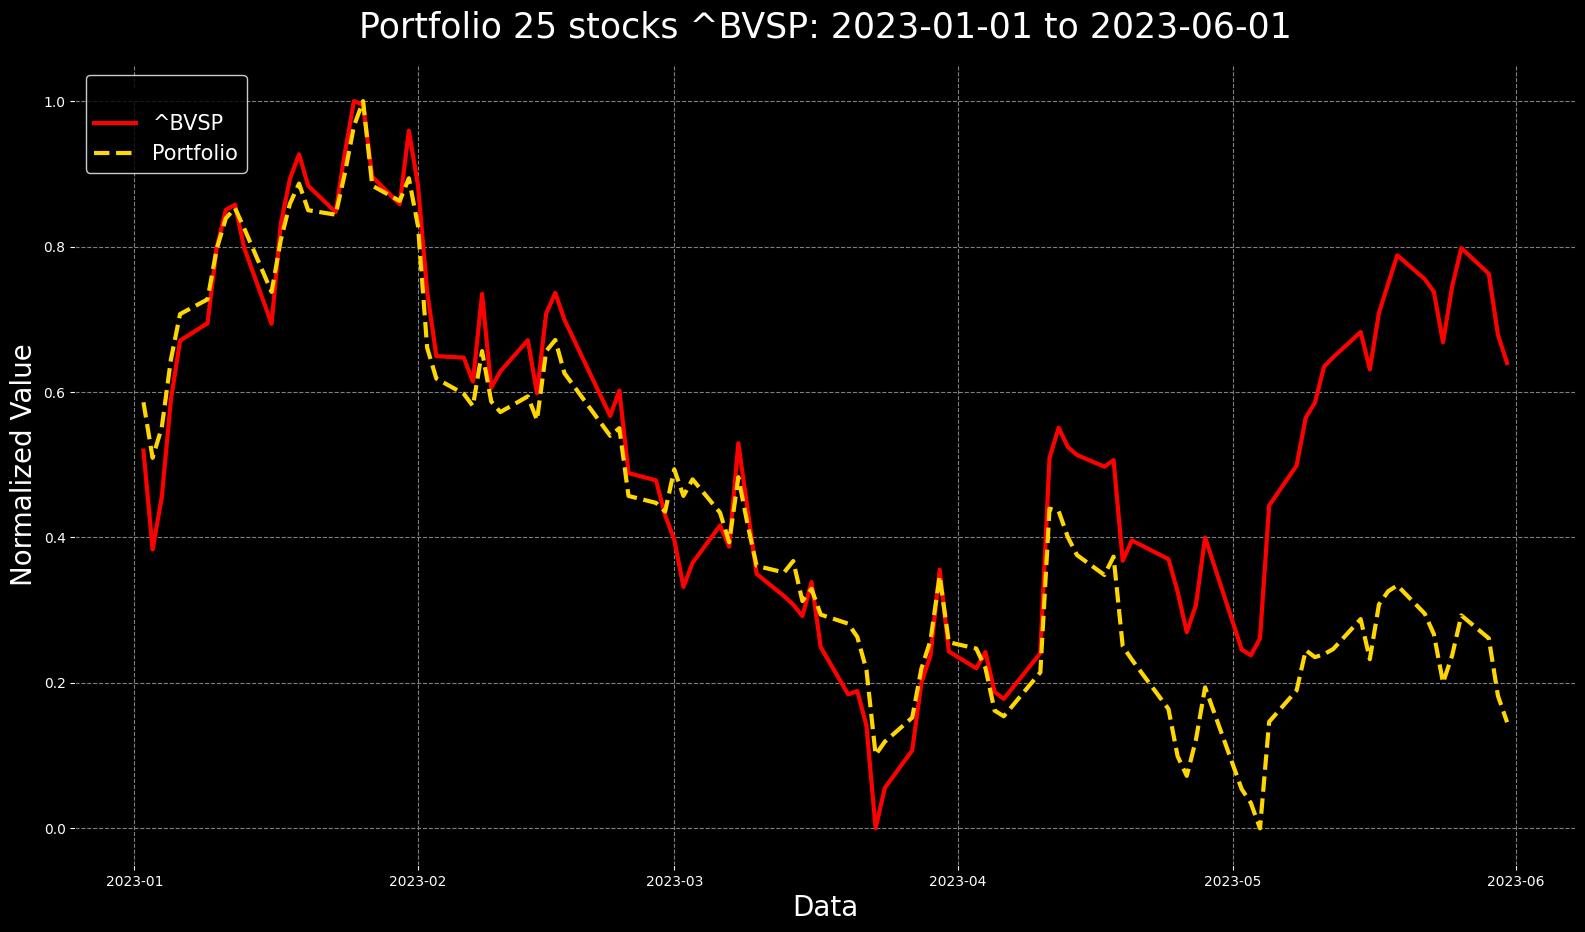

In [19]:
plot_portfolio(portfolio_bvsp, x_bvsp_values_train, y_bvsp_values_train, start_date_train, end_date_train, bvsp_index_ticker)

# 15 ações

In [20]:
portfolio_sp100_15 = create_portfolio(x_sp100_data_train, y_sp100_data_train, portfolio_size=15, max_iterations=10000000)

Set parameter IterationLimit to value 10000000
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
IterationLimit  10000000

Optimize a model with 100 rows, 196 columns and 392 nonzeros
Model fingerprint: 0xbb880e1c
Model has 4851 quadratic objective terms
Variable types: 98 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 5e-04]
  QObjective range [2e-07, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 0.0001821
Presolve time: 0.00s
Presolved: 100 rows, 196 columns, 392 nonzeros
Presolved model has 4851 quadratic objective terms
Variable types: 98 continuous, 98 integer (98 binary)

Root relaxation: objective 9.474217e-08, 621 iterations, 0.02 second

In [22]:
portfolio_bvsp = create_portfolio(x_bvsp_data_train, y_bvsp_data_train, portfolio_size=15, max_iterations=10000000)

Set parameter IterationLimit to value 10000000
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
IterationLimit  10000000

Optimize a model with 86 rows, 168 columns and 336 nonzeros
Model fingerprint: 0x6fb60a97
Model has 3570 quadratic objective terms
Variable types: 84 continuous, 84 integer (84 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 6e-04]
  QObjective range [2e-08, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 0.0003106
Presolve time: 0.01s
Presolved: 86 rows, 168 columns, 336 nonzeros
Presolved model has 3570 quadratic objective terms
Variable types: 84 continuous, 84 integer (84 binary)

Root relaxation: objective 7.596040e-07, 500 iterations, 0.01 seconds 

In [46]:
def plot_portfolio(portfolio, stocks_data, index_data, start_date, end_date, index_name):
    a = [key for key in portfolio if key in stocks_data.columns]
    portfolio_data = stocks_data[a]

    weights = pd.Series(portfolio).reindex(a).values

    scaler = MinMaxScaler()

    portfolio_data_filtered = (portfolio_data * weights).sum(axis=1).loc[start_date:end_date]
    portfolio_data_normalized = scaler.fit_transform(portfolio_data_filtered.values.reshape(-1, 1))

    index_data_filtered = index_data.loc[start_date:end_date]
    index_data_normalized = scaler.fit_transform(index_data_filtered.values.reshape(-1, 1))

    start_date_str = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    end_date_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')

    fig = plt.figure(figsize=(15, 8), facecolor='black')
    eixo = fig.add_axes([0, 0, 1, 1], facecolor='black')

    eixo.plot(index_data_filtered.index, index_data_normalized, color='red', linestyle='-', linewidth=3, label=index_name)
    eixo.plot(portfolio_data_filtered.index, portfolio_data_normalized, color='gold', linestyle='--', linewidth= 3, label="Portfolio")

    eixo.set_title(f"Portfolio 15 stocks {index_name}: {start_date_str} to {end_date_str}", fontsize=25, pad=20, color='white')
    eixo.legend(title="Indicador", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')
    eixo.set_ylabel('Normalized Value', fontsize=20, color='white')
    eixo.set_xlabel('Data', fontsize=20, color='white')
    eixo.tick_params(colors='white')
    eixo.grid(color='gray', linestyle='--')

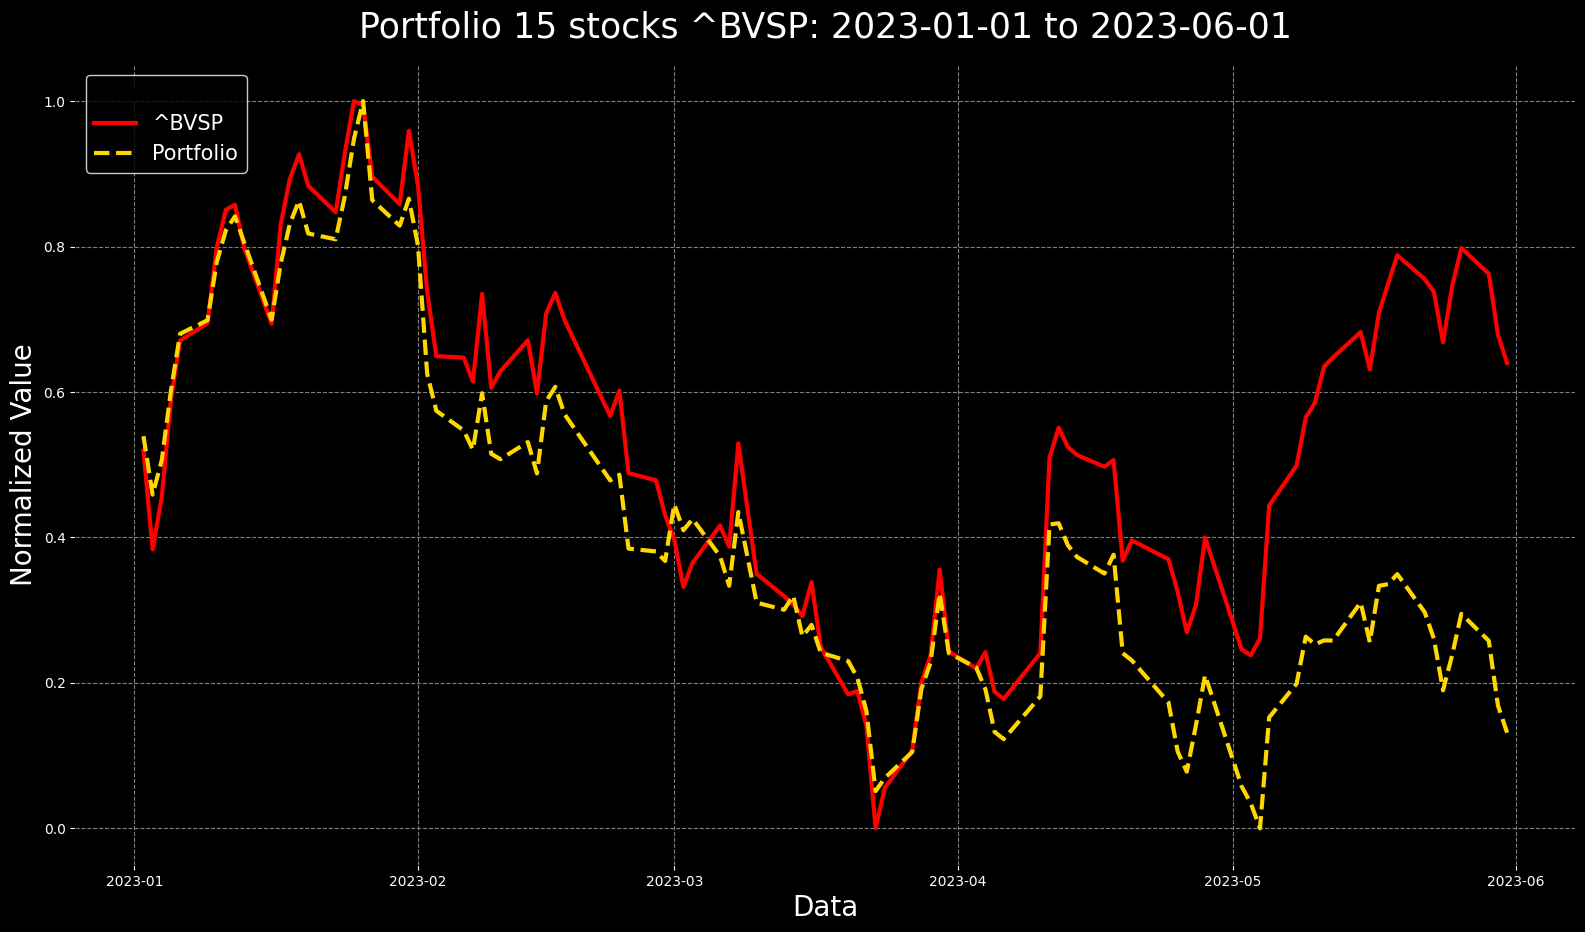

In [47]:
plot_portfolio(portfolio_bvsp, x_bvsp_values_train, y_bvsp_values_train, start_date_train, end_date_train, bvsp_index_ticker)


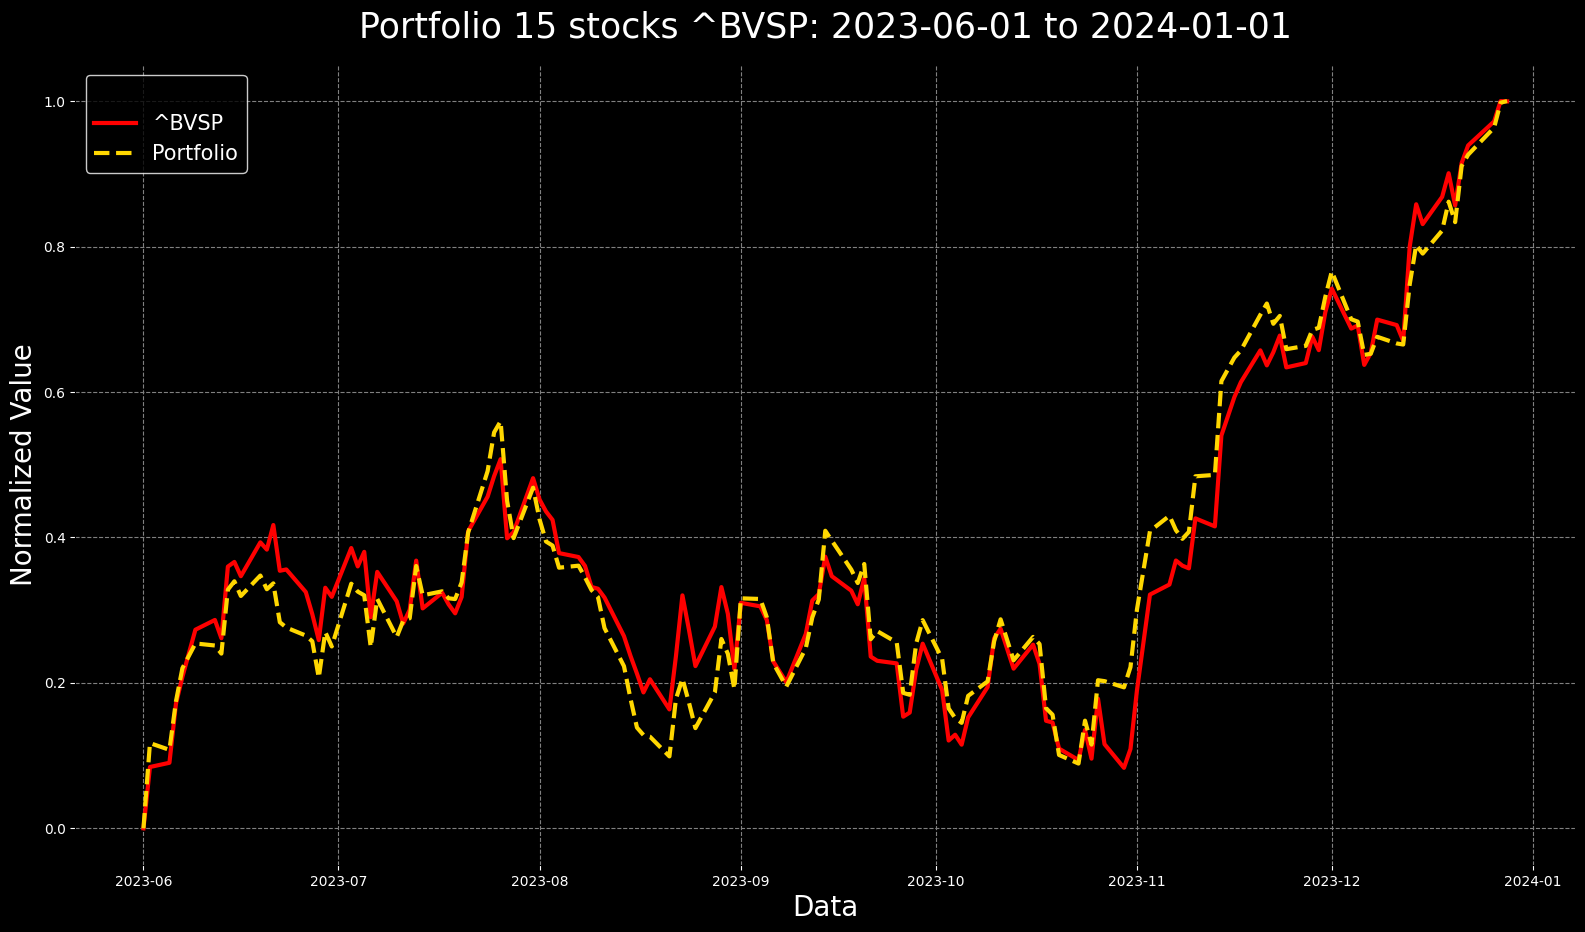

In [49]:
plot_portfolio(portfolio_bvsp, x_bvsp_values_test, y_bvsp_values_test, start_date_test, end_date_test, bvsp_index_ticker)

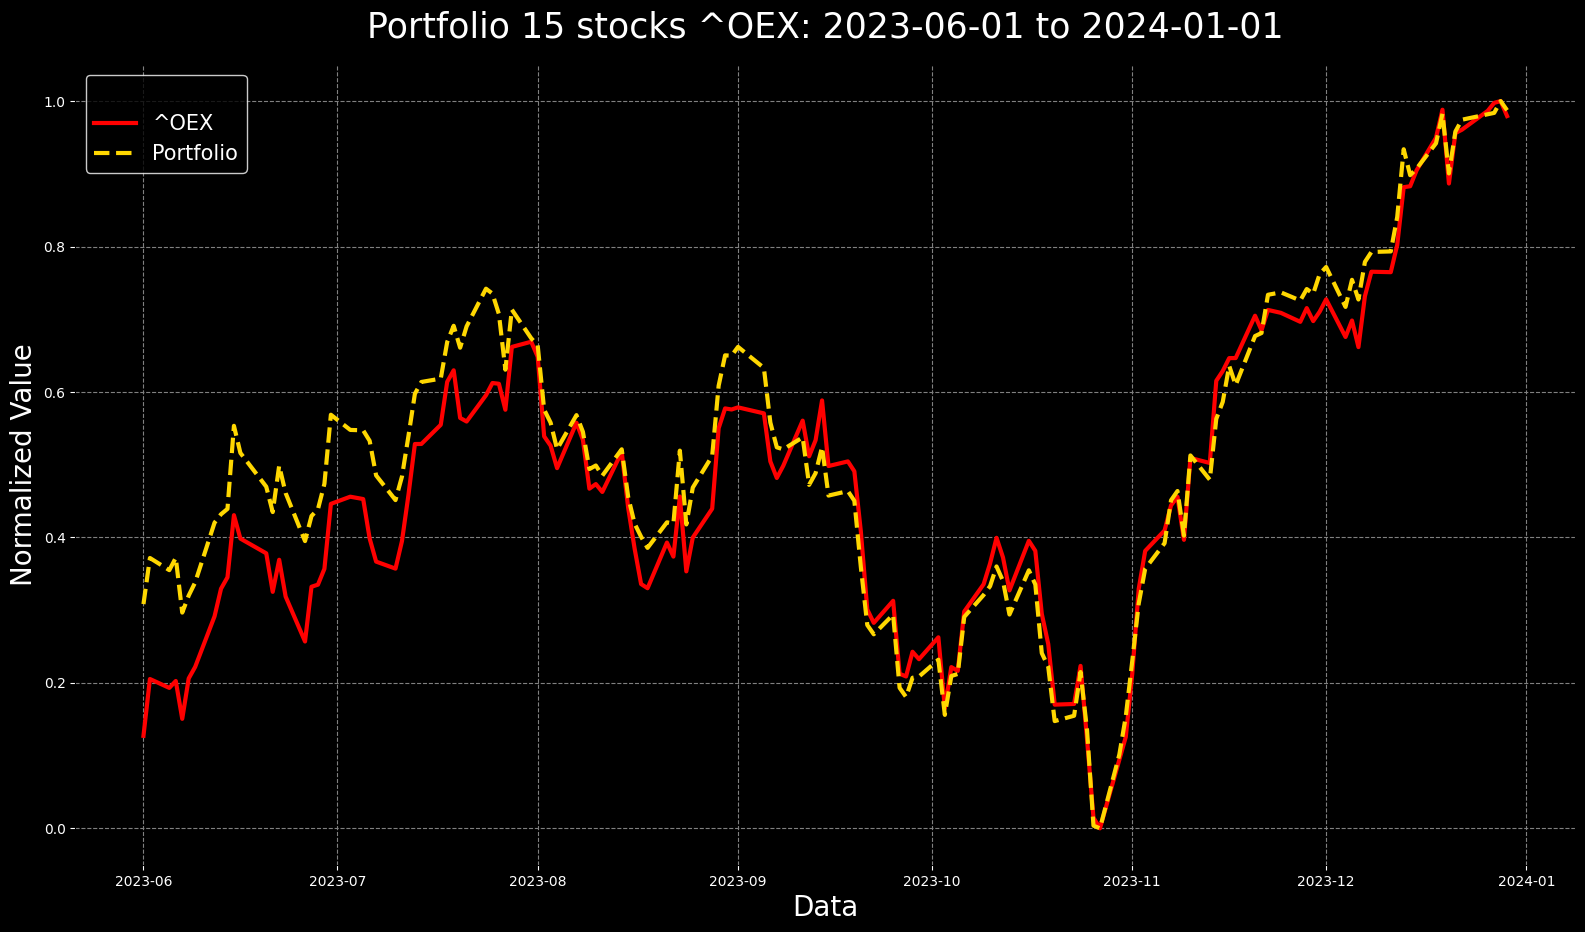

In [ ]:
plot_portfolio(portfolio_sp100, x_sp100_values_test, y_sp100_values_test, start_date_test, end_date_test, sp100_index_ticker)

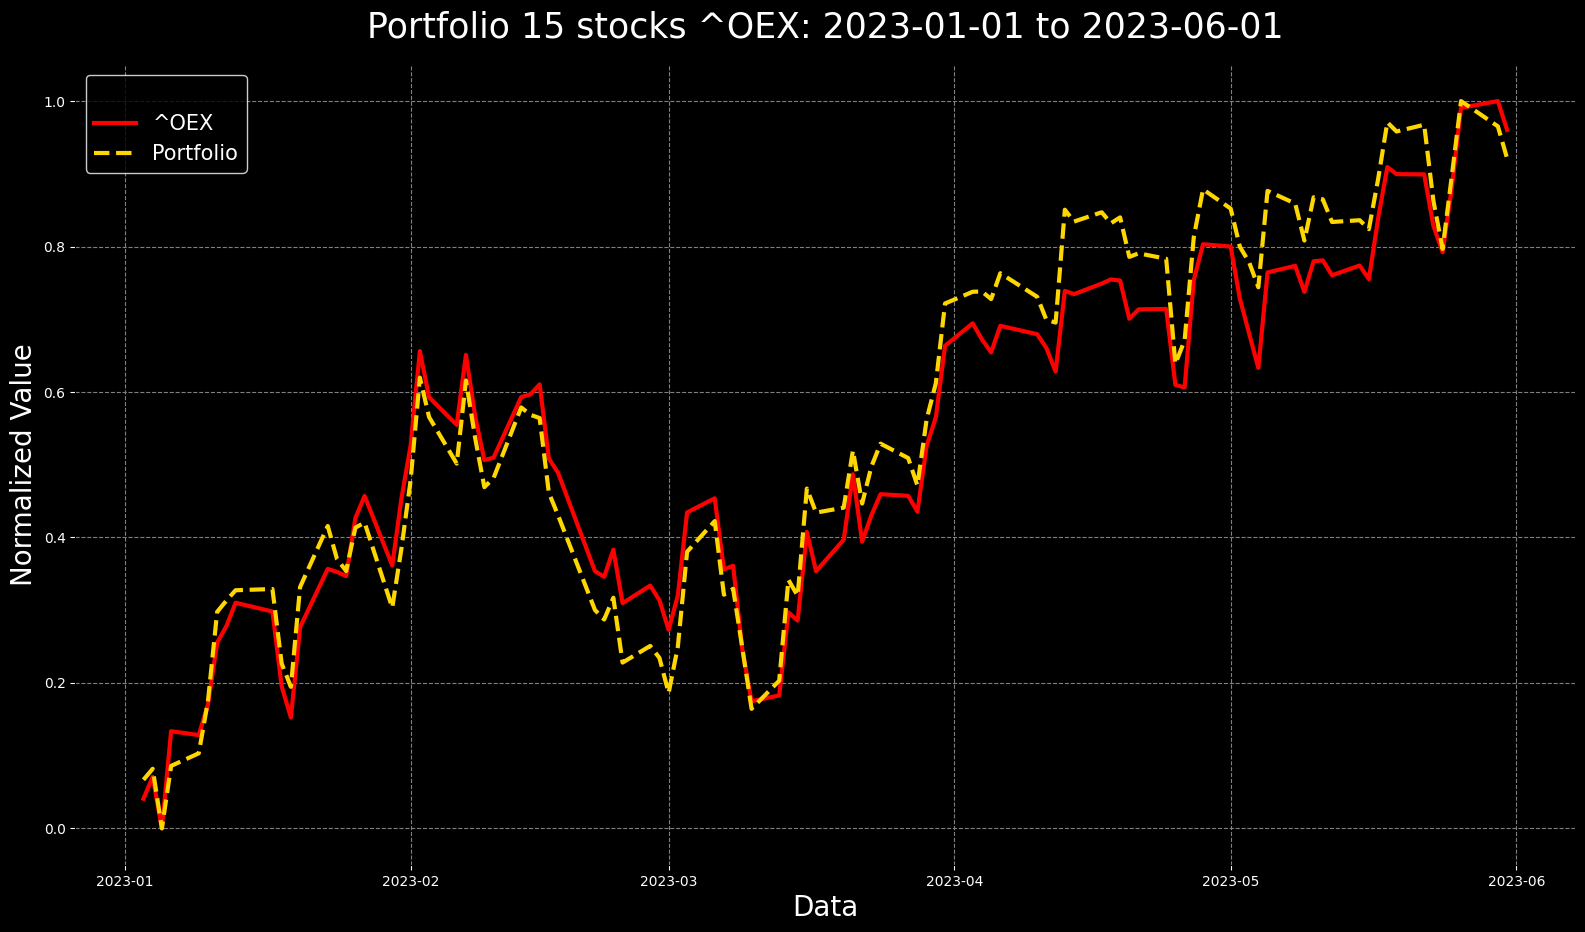

In [ ]:
plot_portfolio(portfolio_sp100, x_sp100_values_train, y_sp100_values_train, start_date_train, end_date_train, sp100_index_ticker)

#Portfolio com 10

In [23]:
portfolio_sp100_10 = create_portfolio(x_sp100_data_train, y_sp100_data_train, portfolio_size=10, max_iterations=10000000)

Set parameter IterationLimit to value 10000000
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
IterationLimit  10000000

Optimize a model with 100 rows, 196 columns and 392 nonzeros
Model fingerprint: 0xb4e24cf9
Model has 4851 quadratic objective terms
Variable types: 98 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 5e-04]
  QObjective range [2e-07, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 0.0001821
Presolve time: 0.01s
Presolved: 100 rows, 196 columns, 392 nonzeros
Presolved model has 4851 quadratic objective terms
Variable types: 98 continuous, 98 integer (98 binary)

Root relaxation: objective 9.474217e-08, 613 iterations, 0.02 second

In [24]:
portfolio_bvsp_10 = create_portfolio(x_bvsp_data_train, y_bvsp_data_train, portfolio_size=10, max_iterations=10000000)

Set parameter IterationLimit to value 10000000
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
IterationLimit  10000000

Optimize a model with 86 rows, 168 columns and 336 nonzeros
Model fingerprint: 0xc99a00bf
Model has 3570 quadratic objective terms
Variable types: 84 continuous, 84 integer (84 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 6e-04]
  QObjective range [2e-08, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 0.0003106
Presolve time: 0.01s
Presolved: 86 rows, 168 columns, 336 nonzeros
Presolved model has 3570 quadratic objective terms
Variable types: 84 continuous, 84 integer (84 binary)

Root relaxation: objective 7.596040e-07, 490 iterations, 0.01 seconds 

In [50]:
def plot_portfolio(portfolio, stocks_data, index_data, start_date, end_date, index_name):
    a = [key for key in portfolio if key in stocks_data.columns]
    portfolio_data = stocks_data[a]

    weights = pd.Series(portfolio).reindex(a).values

    scaler = MinMaxScaler()

    portfolio_data_filtered = (portfolio_data * weights).sum(axis=1).loc[start_date:end_date]
    portfolio_data_normalized = scaler.fit_transform(portfolio_data_filtered.values.reshape(-1, 1))

    index_data_filtered = index_data.loc[start_date:end_date]
    index_data_normalized = scaler.fit_transform(index_data_filtered.values.reshape(-1, 1))

    start_date_str = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    end_date_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')

    fig = plt.figure(figsize=(15, 8), facecolor='black')
    eixo = fig.add_axes([0, 0, 1, 1], facecolor='black')

    eixo.plot(index_data_filtered.index, index_data_normalized, color='red', linestyle='-', linewidth=3, label=index_name)
    eixo.plot(portfolio_data_filtered.index, portfolio_data_normalized, color='gold', linestyle='--', linewidth= 3, label="Portfolio")

    eixo.set_title(f"Portfolio 10 stocks {index_name}: {start_date_str} to {end_date_str}", fontsize=25, pad=20, color='white')
    eixo.legend(title="Indicador", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')
    eixo.set_ylabel('Normalized Value', fontsize=20, color='white')
    eixo.set_xlabel('Data', fontsize=20, color='white')
    eixo.tick_params(colors='white')
    eixo.grid(color='gray', linestyle='--')

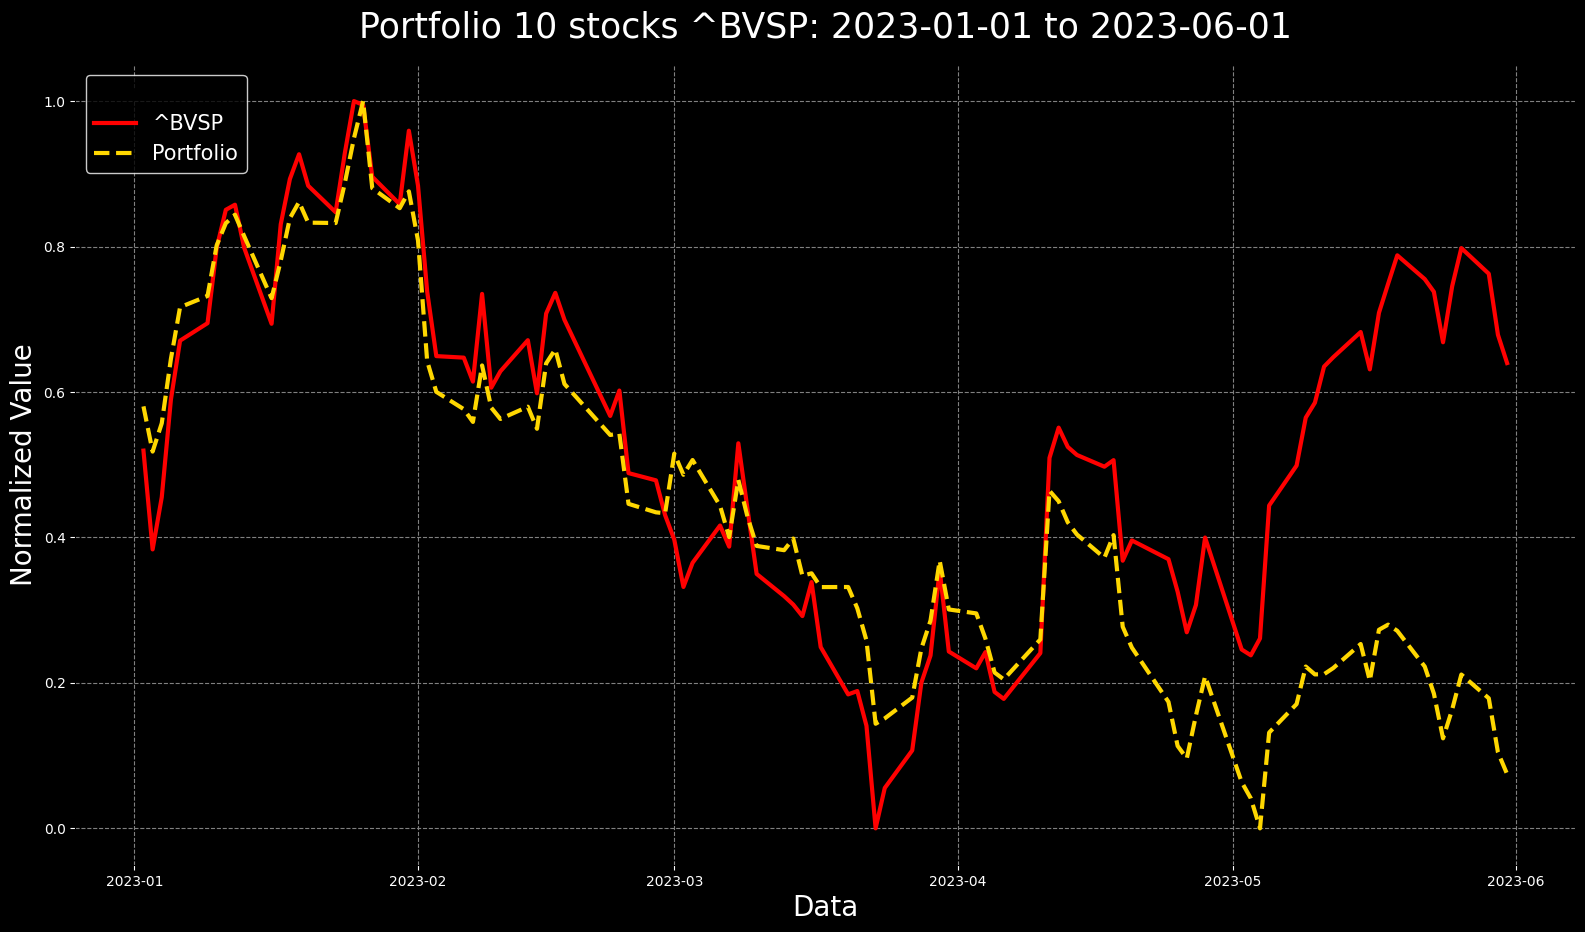

In [51]:
plot_portfolio(portfolio_bvsp_10, x_bvsp_values_train, y_bvsp_values_train, start_date_train, end_date_train, bvsp_index_ticker)


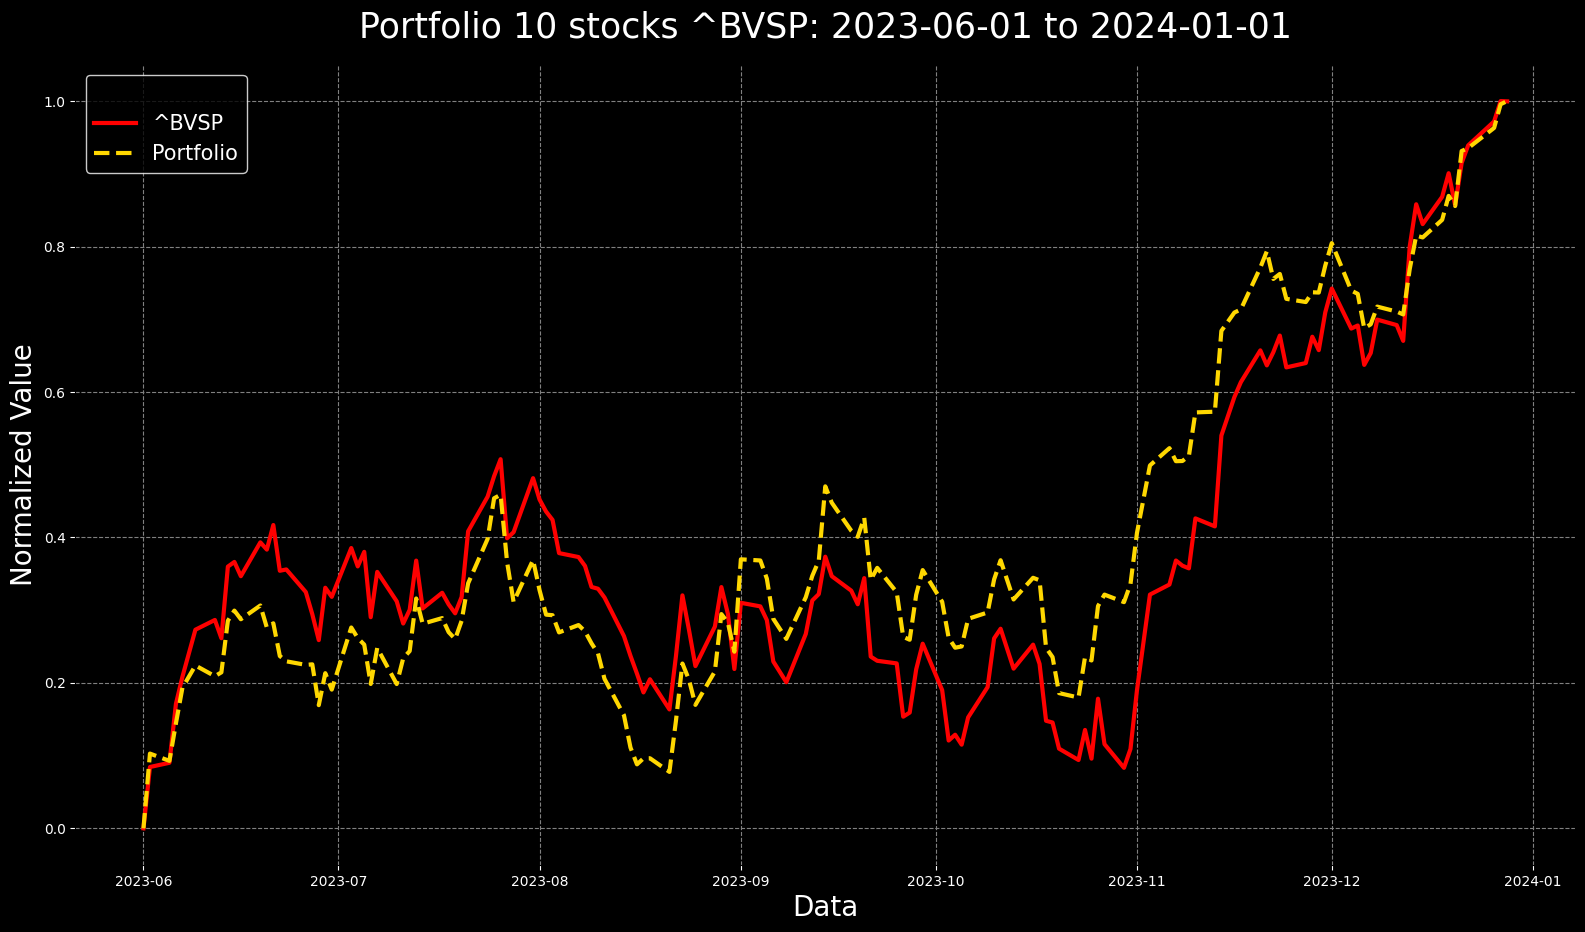

In [52]:
plot_portfolio(portfolio_bvsp_10, x_bvsp_values_test, y_bvsp_values_test, start_date_test, end_date_test, bvsp_index_ticker)

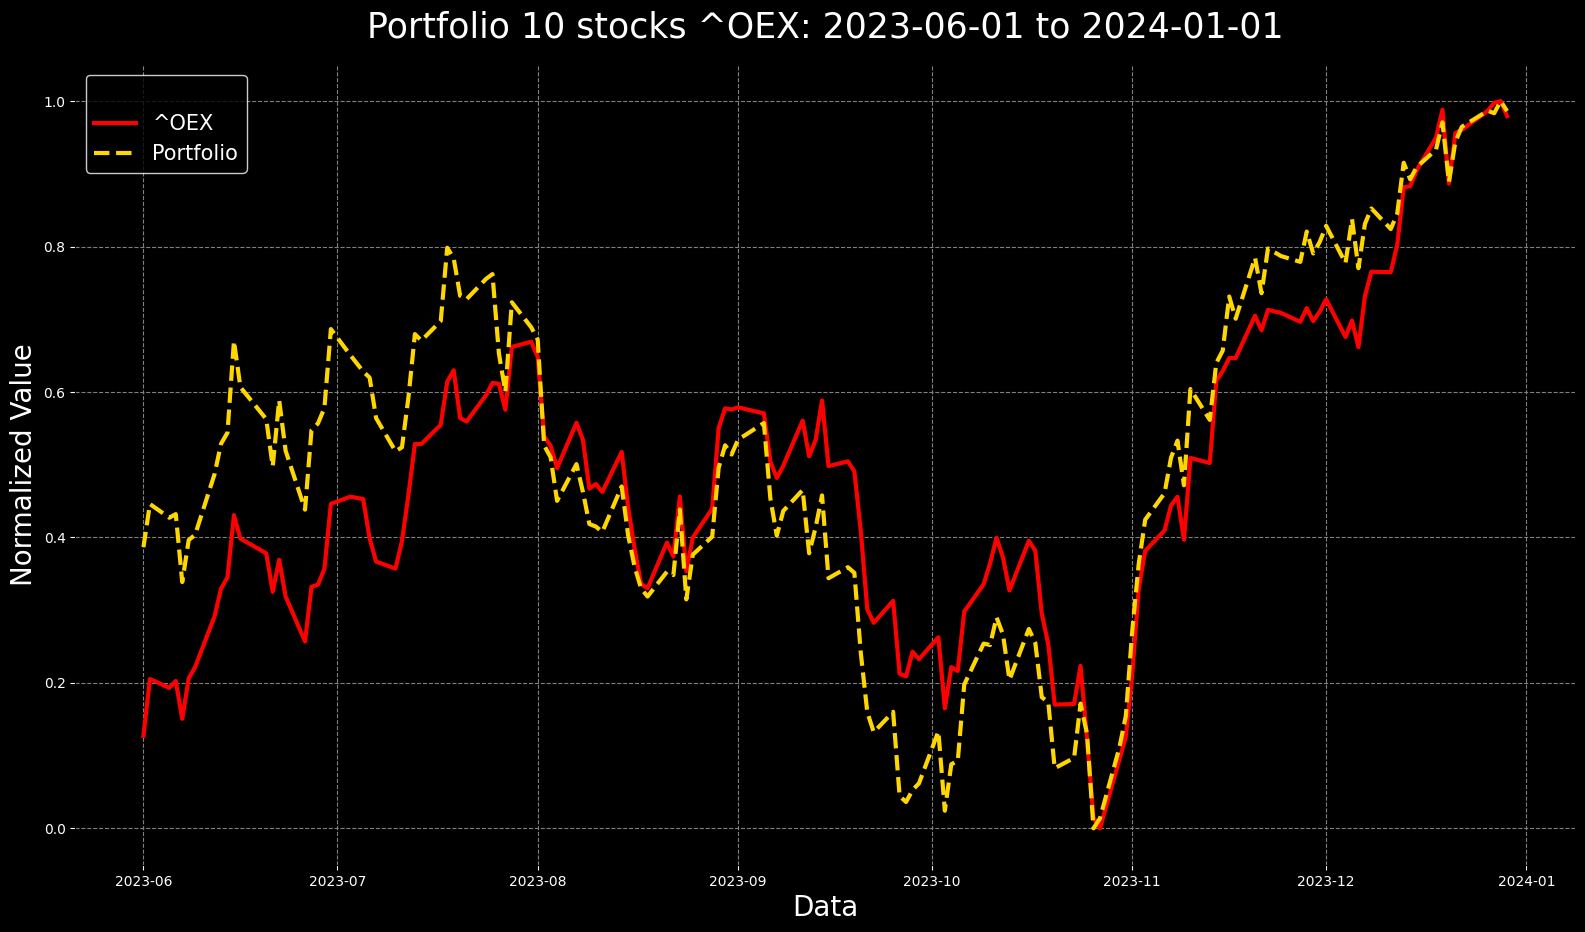

In [53]:
plot_portfolio(portfolio_sp100_10, x_sp100_values_test, y_sp100_values_test, start_date_test, end_date_test, sp100_index_ticker)

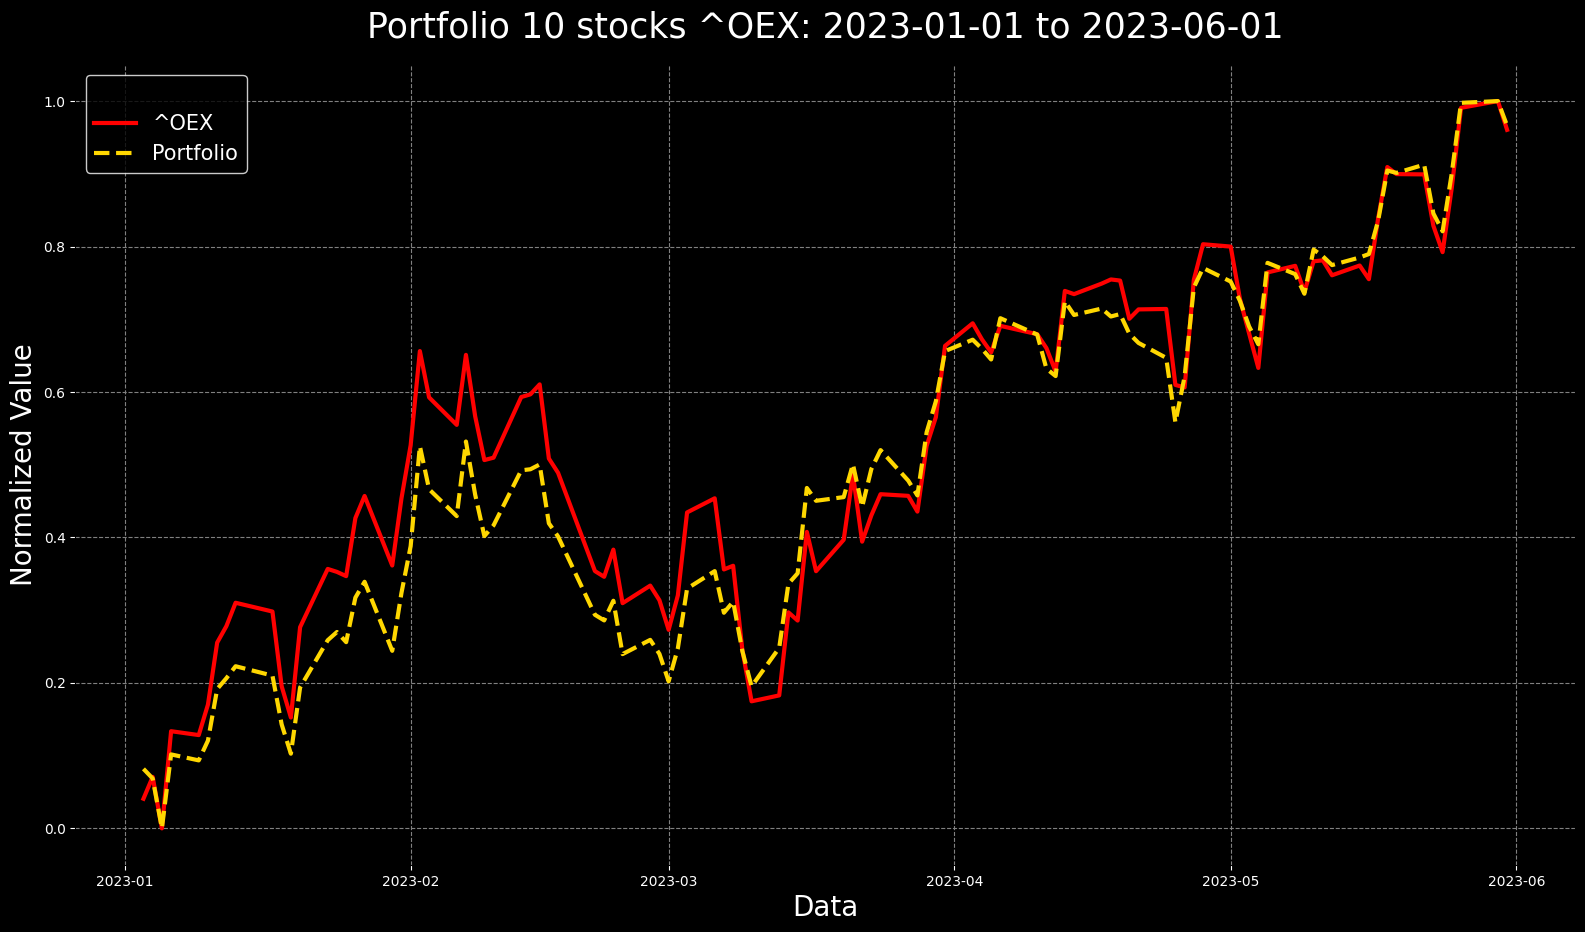

In [54]:
plot_portfolio(portfolio_sp100_10, x_sp100_values_train, y_sp100_values_train, start_date_train, end_date_train, sp100_index_ticker)

## Variance plots:

In [ ]:
def plot_portfolio_variance(portfolio, stocks_data, index_data, start_date, end_date, index_name):
    a = [key for key in portfolio if key in stocks_data.columns]
    portfolio_data = stocks_data[a]

    weights = pd.Series(portfolio).reindex(a).values

    portfolio_data_filtered = (portfolio_data * weights).sum(axis=1).loc[start_date:end_date]

    index_data_filtered = index_data.loc[start_date:end_date]

    start_date_str = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    end_date_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')

    fig = plt.figure(figsize=(12, 5))
    eixo = fig.add_axes([0, 0, 1, 1])
    plt.figure(facecolor='black')
    eixo.plot(index_data_filtered.index, index_data_filtered, color='gold', linestyle='-', linewidth=3, label=index_name)
    eixo.plot(portfolio_data_filtered.index, portfolio_data_filtered, color='red', linestyle='--', linewidth=1, label="Portfolio")

    eixo.set_title(f"Portfolio 25 stocks {index_name}: {start_date_str} to {end_date_str}", fontsize=25, pad=20, color='white')
    eixo.legend(title="Indicador", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')
    eixo.set_ylabel('Normalized Value', fontsize=20, color='white')
    eixo.set_xlabel('Data', fontsize=20, color='white')
    eixo.tick_params(colors='white')
    eixo.grid(color='gray', linestyle='--')

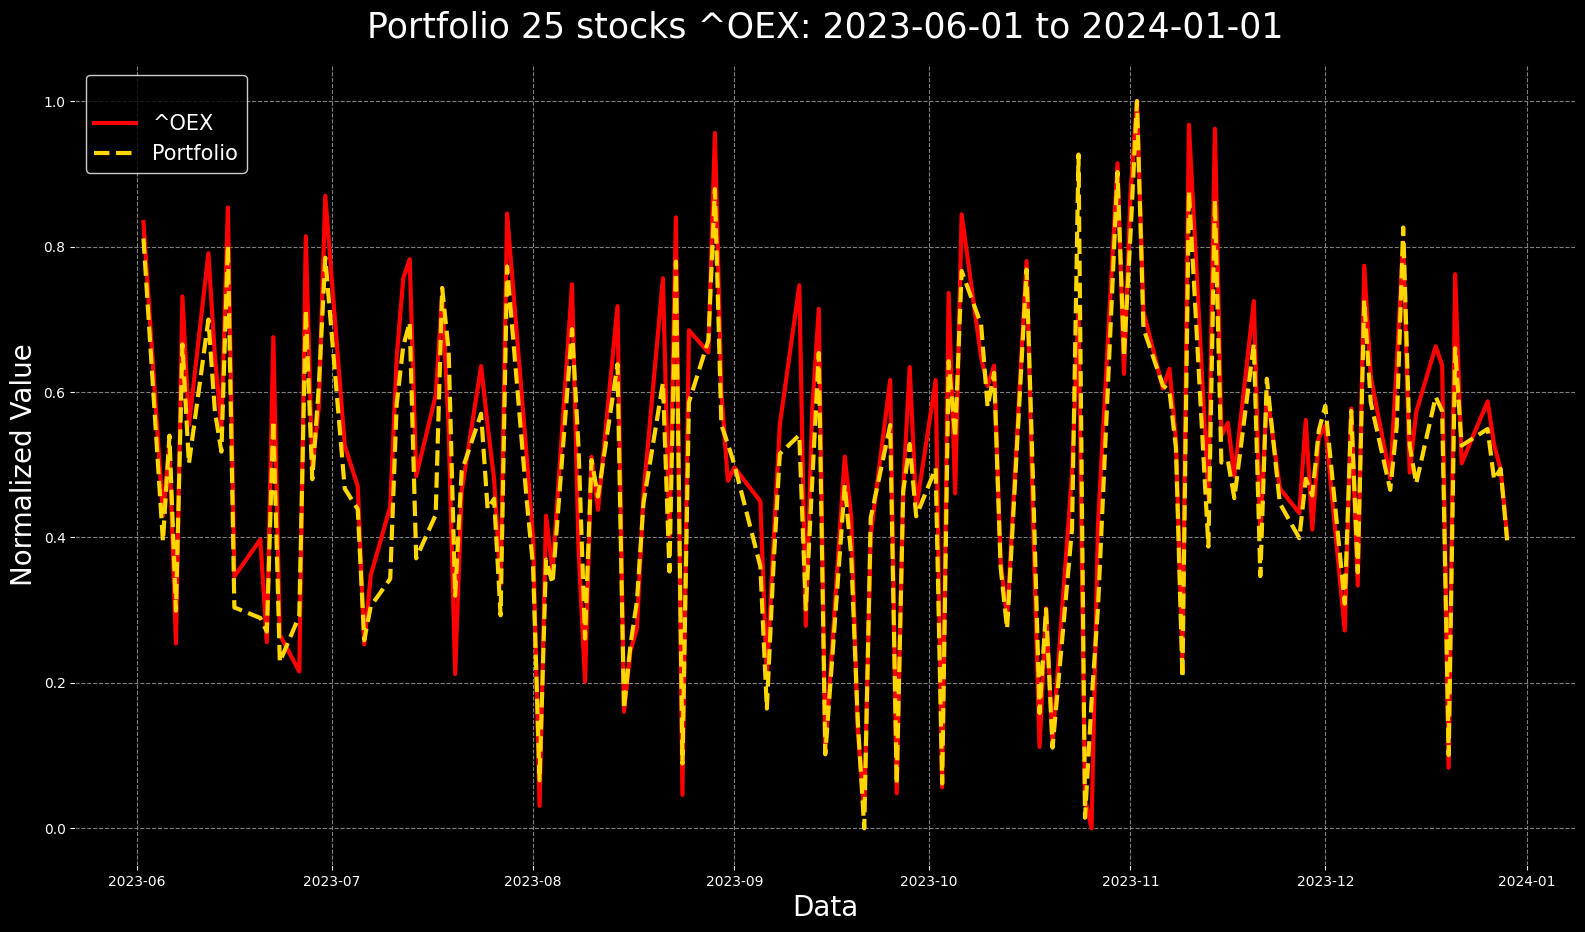

In [ ]:
plot_portfolio(portfolio_sp100, x_sp100_data_test, y_sp100_data_test, start_date_test, end_date_test, sp100_index_ticker)

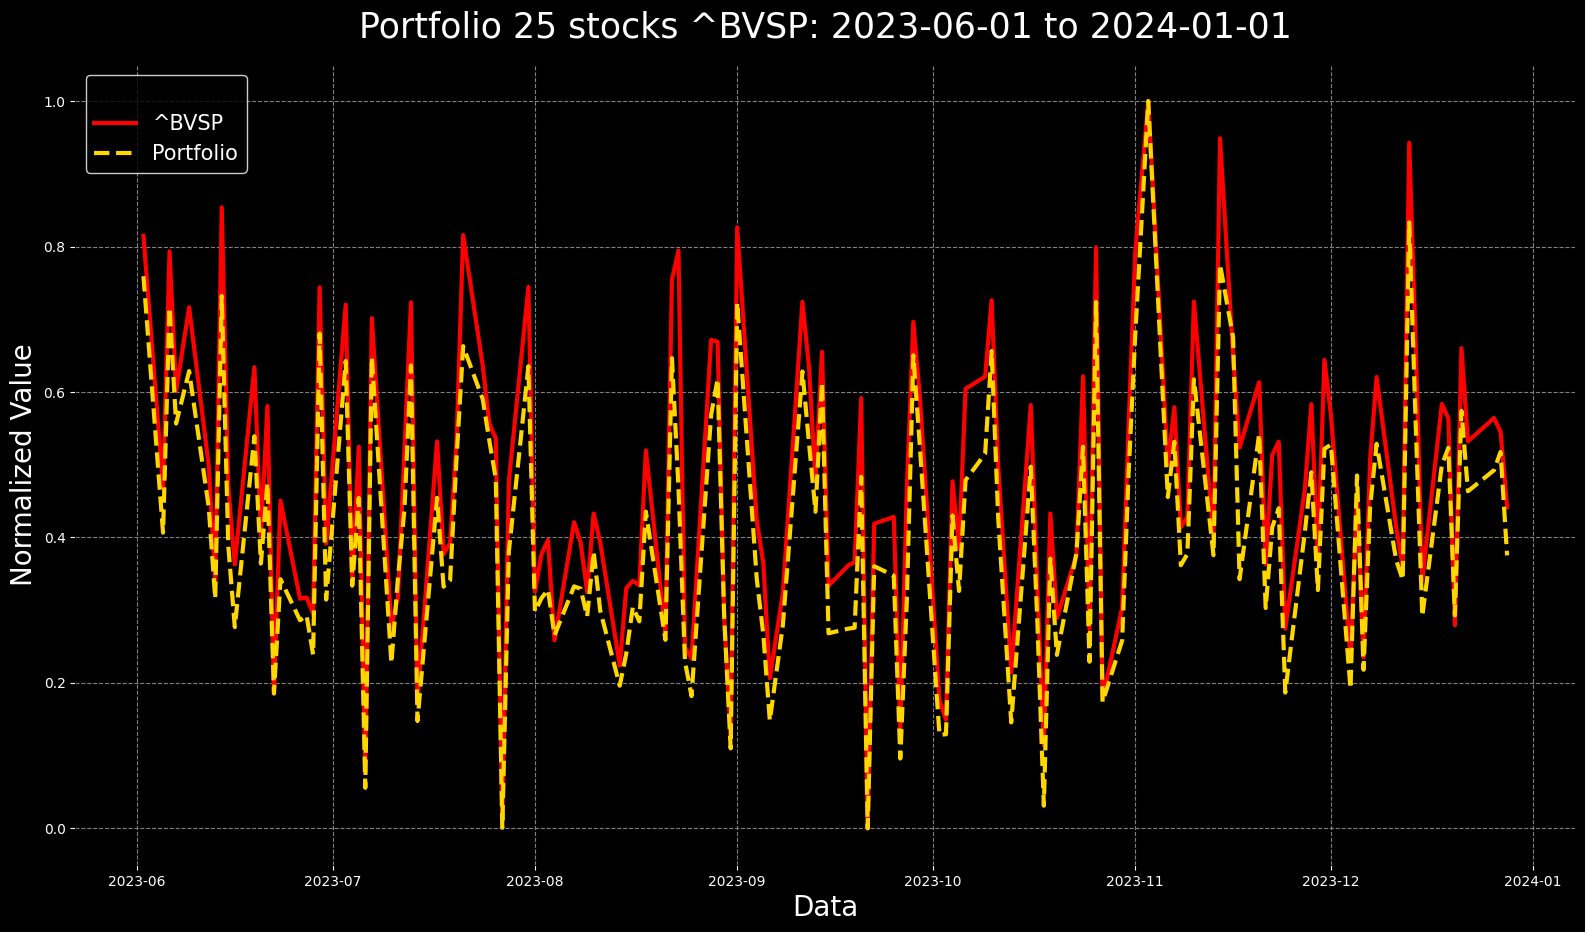

In [ ]:
plot_portfolio(portfolio_bvsp, x_bvsp_data_test, y_bvsp_data_test, start_date_test, end_date_test, bvsp_index_ticker)

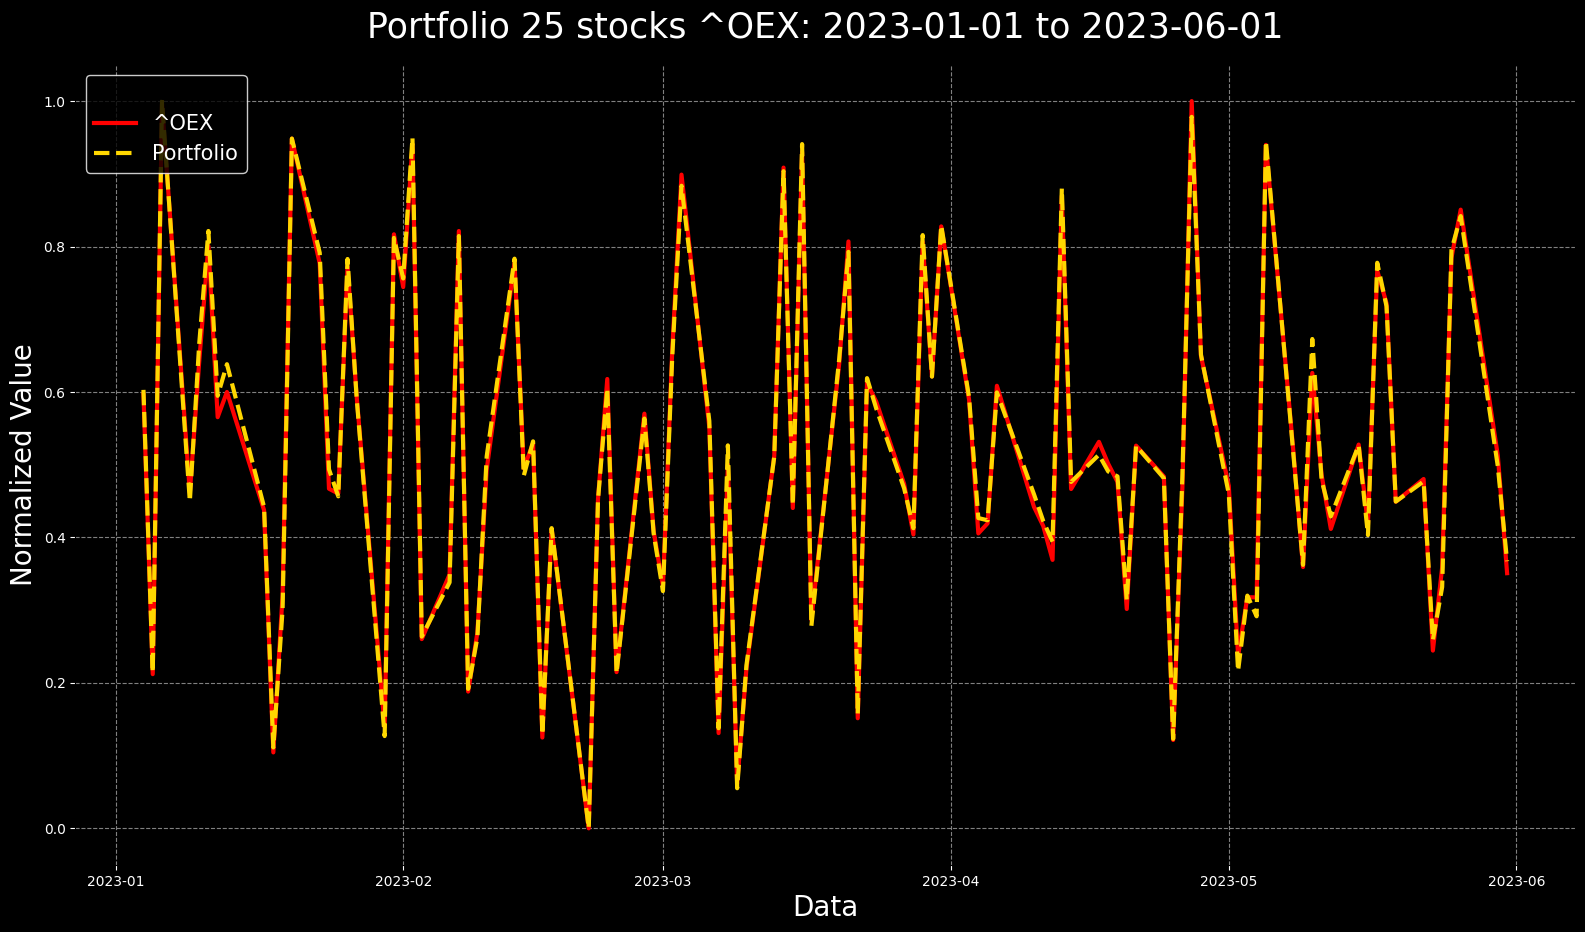

In [ ]:
plot_portfolio(portfolio_sp100, x_sp100_data_train, y_sp100_data_train, start_date_train, end_date_train, sp100_index_ticker)

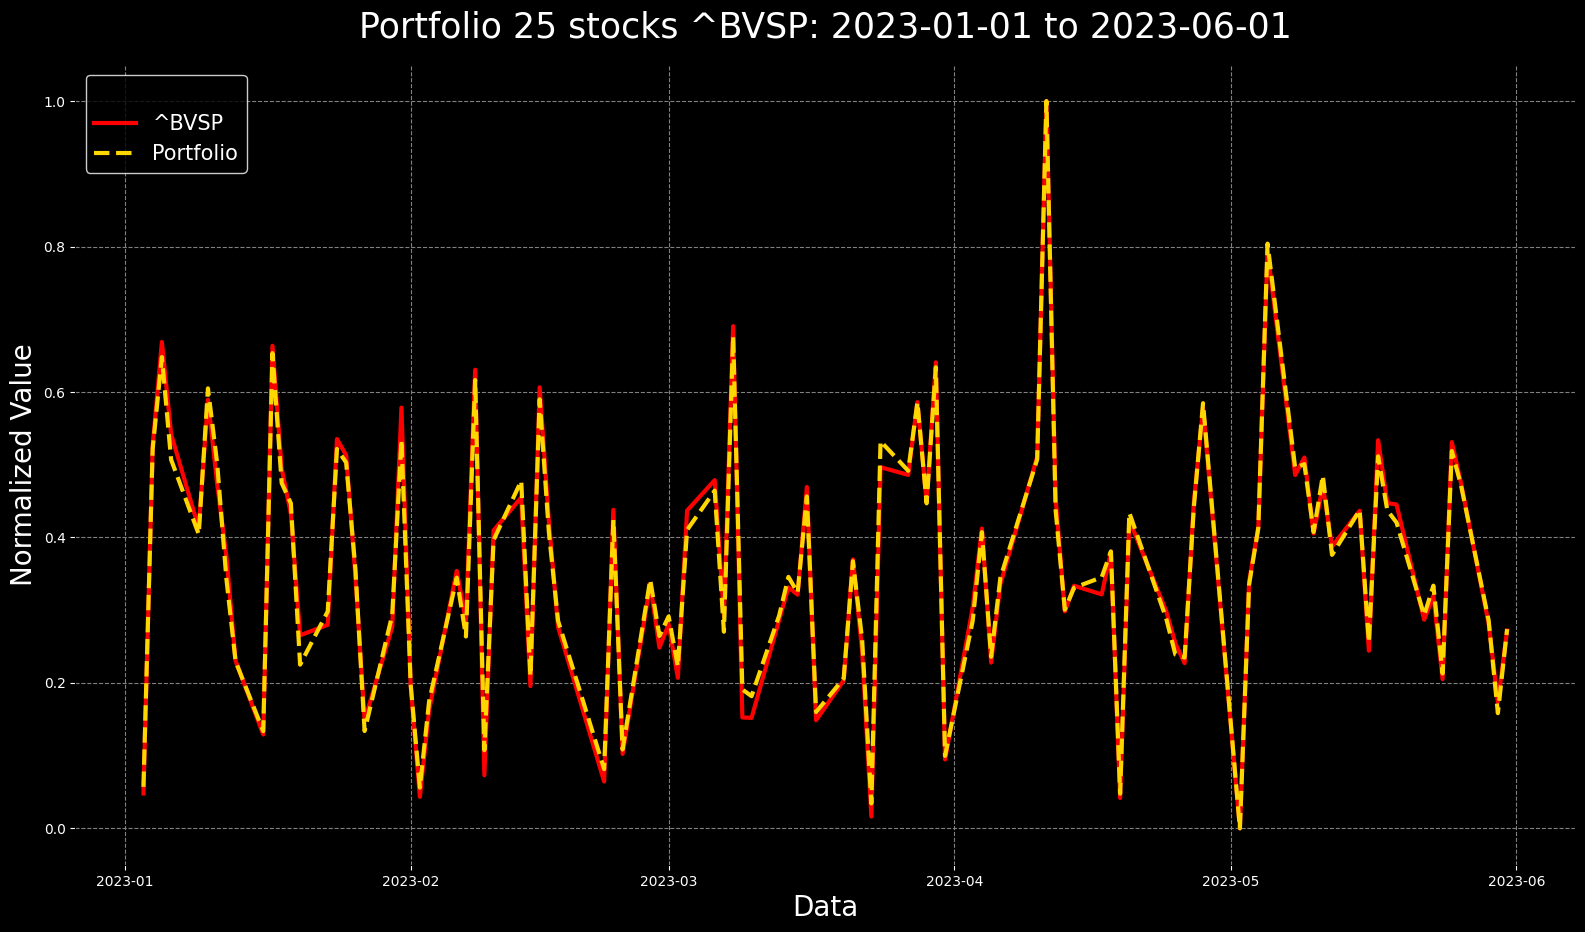

In [ ]:
plot_portfolio(portfolio_bvsp, x_bvsp_data_train, y_bvsp_data_train, start_date_train, end_date_train, bvsp_index_ticker)

# TreeMap

25

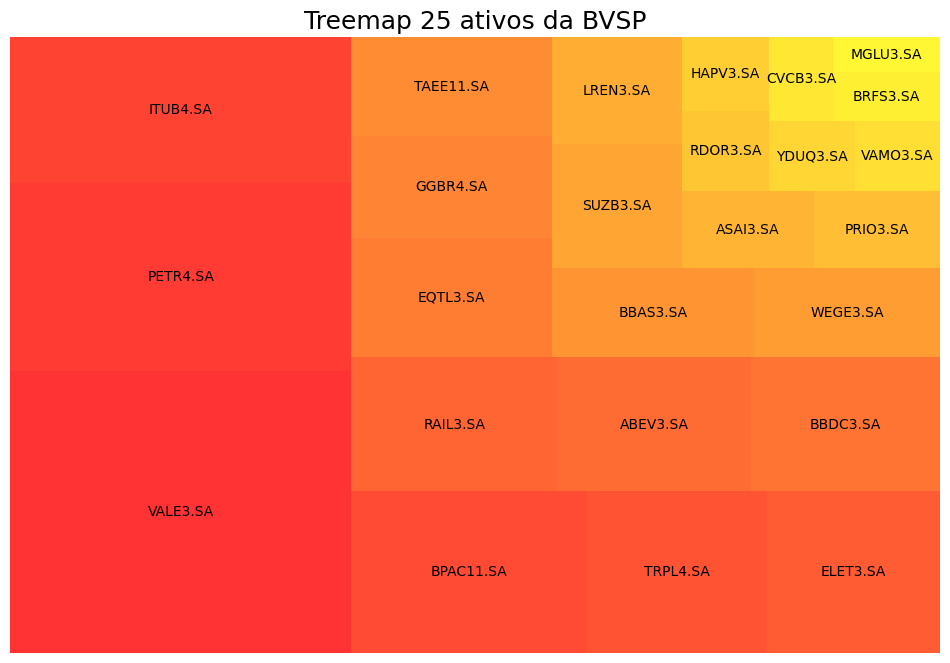

In [39]:
!pip install squarify

import matplotlib.pyplot as plt
import squarify

# Dados
stocks = {
    "VALE3.SA": 0.1682,
    "PETR4.SA": 0.1119,
    "ITUB4.SA": 0.0869,
    "BPAC11.SA": 0.0664,
    "TRPL4.SA": 0.0510,
    "ELET3.SA": 0.0488,
    "RAIL3.SA": 0.0483,
    "ABEV3.SA": 0.0454,
    "BBDC3.SA": 0.0442,
    "EQTL3.SA": 0.0418,
    "GGBR4.SA": 0.0357,
    "TAEE11.SA": 0.0347,
    "BBAS3.SA": 0.0316,
    "WEGE3.SA": 0.0290,
    "SUZB3.SA": 0.0280,
    "LREN3.SA": 0.0244,
    "ASAI3.SA": 0.0177,
    "PRIO3.SA": 0.0169,
    "RDOR3.SA": 0.0121,
    "HAPV3.SA": 0.0111,
    "YDUQ3.SA": 0.0105,
    "VAMO3.SA": 0.0103,
    "CVCB3.SA": 0.0095,
    "BRFS3.SA": 0.0092,
    "MGLU3.SA": 0.0065,
}

# Preparar dados
labels = list(stocks.keys())
values = list(stocks.values())

# Gerar cores com gradiente de outono
colors = plt.cm.autumn([i / len(values) for i in range(len(values))])

# Criar o treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=values, label=labels, alpha=0.8, color=colors)
plt.title("Treemap 25 ativos da BVSP", fontsize=18)
plt.axis('off')
plt.show()




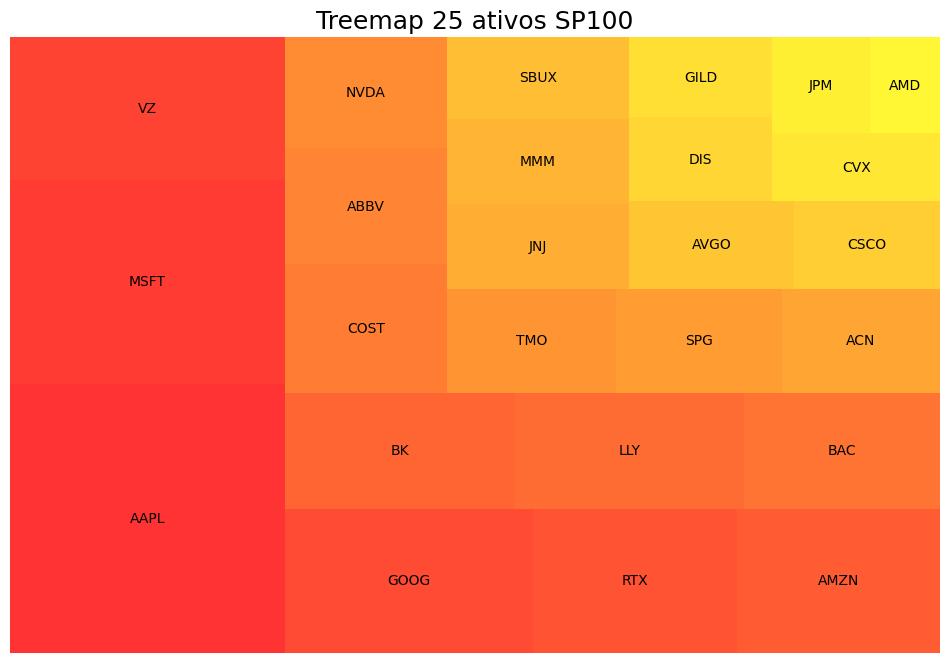

In [40]:
stocks = {
    "AAPL": 0.1291,
    "MSFT": 0.0978,
    "VZ": 0.0685,
    "GOOG": 0.0625,
    "RTX": 0.0513,
    "AMZN": 0.0510,
    "BK": 0.0466,
    "LLY": 0.0463,
    "BAC": 0.0397,
    "COST": 0.0365,
    "ABBV": 0.0328,
    "NVDA": 0.0315,
    "TMO": 0.0308,
    "SPG": 0.0303,
    "ACN": 0.0288,
    "JNJ": 0.0271,
    "MMM": 0.0270,
    "SBUX": 0.0261,
    "AVGO": 0.0252,
    "CSCO": 0.0222,
    "DIS": 0.0210,
    "GILD": 0.0201,
    "CVX": 0.0199,
    "JPM": 0.0164,
    "AMD": 0.0118,
}

# Preparar dados
labels = list(stocks.keys())
values = list(stocks.values())

# Gerar cores com gradiente de outono
colors = plt.cm.autumn([i / len(values) for i in range(len(values))])

# Criar o treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=values, label=labels, alpha=0.8, color=colors)
plt.title("Treemap 25 ativos SP100", fontsize=18)
plt.axis('off')
plt.show()


15

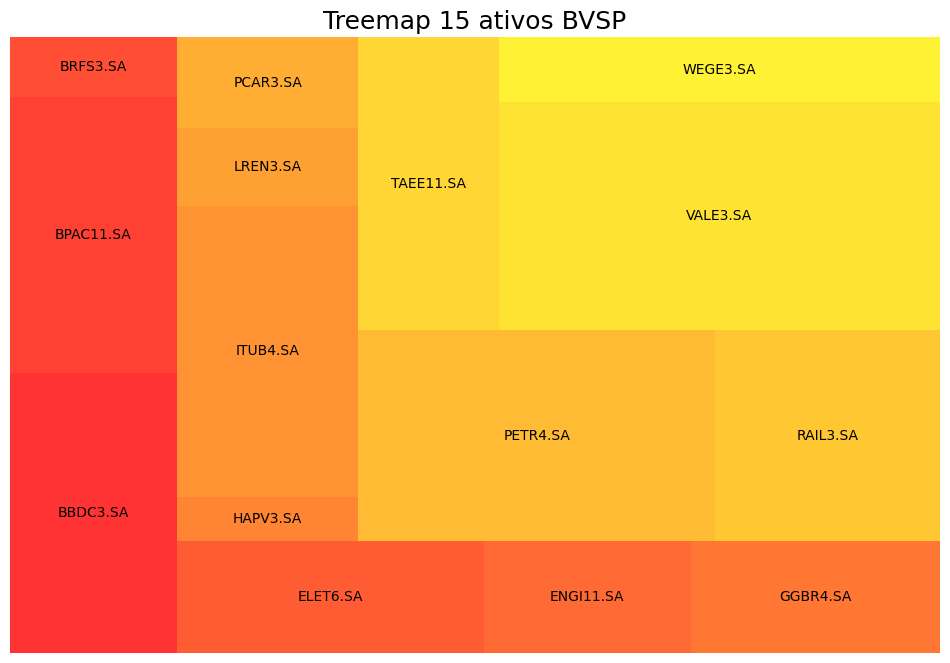

In [41]:
stocks = {
    "BBDC3.SA": 0.0816,
    "BPAC11.SA": 0.0802,
    "BRFS3.SA": 0.0174,
    "ELET6.SA": 0.0600,
    "ENGI11.SA": 0.0405,
    "GGBR4.SA": 0.0487,
    "HAPV3.SA": 0.0141,
    "ITUB4.SA": 0.0922,
    "LREN3.SA": 0.0247,
    "PCAR3.SA": 0.0288,
    "PETR4.SA": 0.1313,
    "RAIL3.SA": 0.0829,
    "TAEE11.SA": 0.0718,
    "VALE3.SA": 0.1754,
    "WEGE3.SA": 0.0500,
}

# Preparar dados
labels = list(stocks.keys())
values = list(stocks.values())

# Gerar cores com gradiente de outono
colors = plt.cm.autumn([i / len(values) for i in range(len(values))])

# Criar o treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=values, label=labels, alpha=0.8, color=colors)
plt.title("Treemap 15 ativos BVSP", fontsize=18)
plt.axis('off')
plt.show()

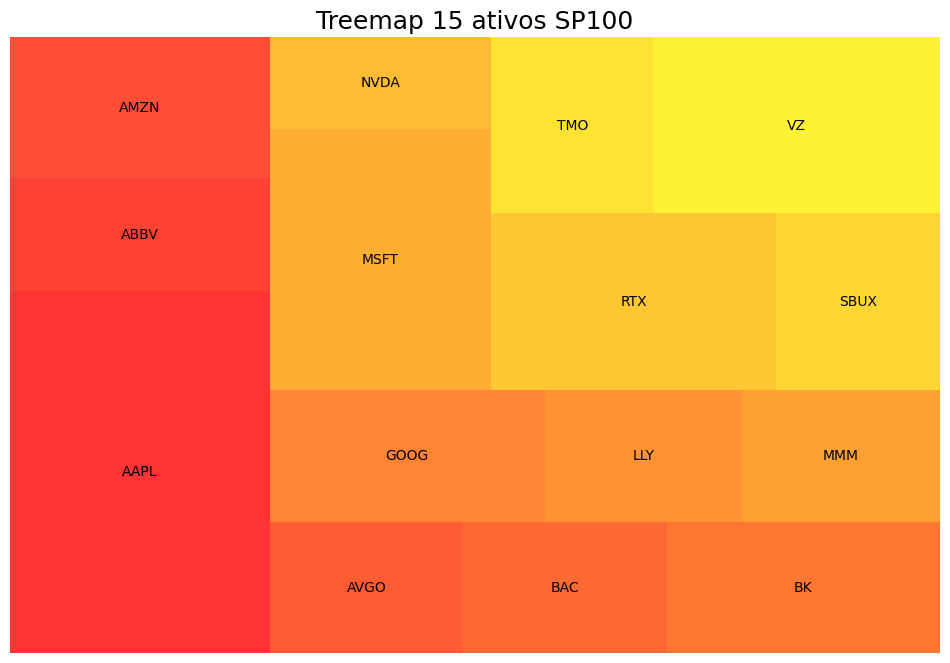

In [42]:
stocks = {
    "AAPL": 0.1641,
    "ABBV": 0.0511,
    "AMZN": 0.0641,
    "AVGO": 0.0441,
    "BAC": 0.0464,
    "BK": 0.0623,
    "GOOG": 0.0638,
    "LLY": 0.0457,
    "MMM": 0.0460,
    "MSFT": 0.1007,
    "NVDA": 0.0357,
    "RTX": 0.0875,
    "SBUX": 0.0504,
    "TMO": 0.0498,
    "VZ": 0.0884,
}

# Preparar dados
labels = list(stocks.keys())
values = list(stocks.values())

# Gerar cores com gradiente de outono
colors = plt.cm.autumn([i / len(values) for i in range(len(values))])

# Criar o treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=values, label=labels, alpha=0.8, color=colors)
plt.title("Treemap 15 ativos SP100", fontsize=18)
plt.axis('off')
plt.show()


10

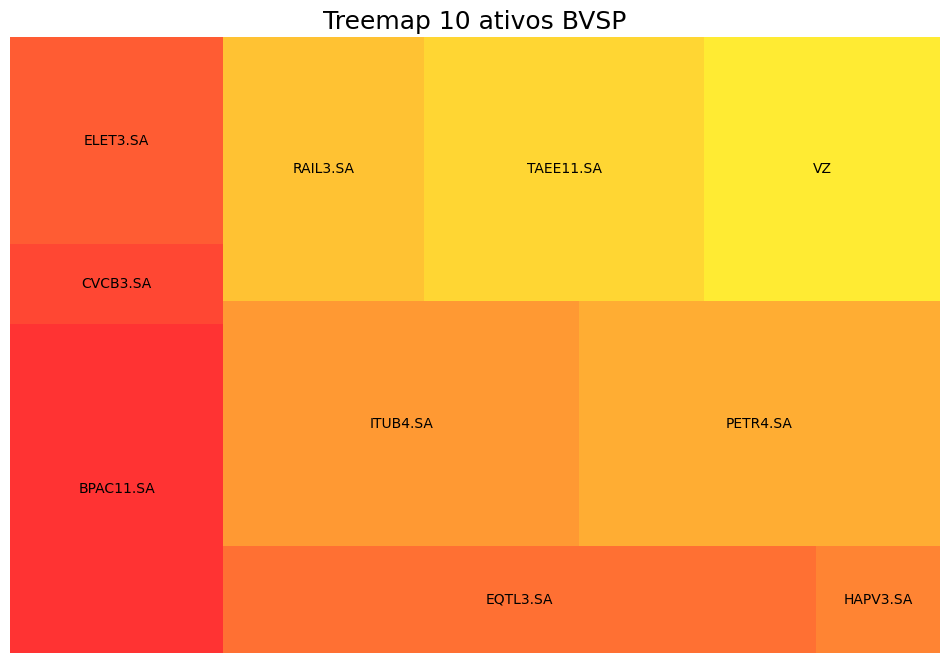

In [43]:

stocks = {
    "BPAC11.SA": 0.1034,
    "CVCB3.SA": 0.0250,
    "ELET3.SA": 0.0650,
    "EQTL3.SA": 0.0936,
    "HAPV3.SA": 0.0196,
    "ITUB4.SA": 0.1284,
    "PETR4.SA": 0.1302,
    "RAIL3.SA": 0.0781,
    "TAEE11.SA": 0.1085,
    "VZ": 0.0917,
}

# Preparar dados
labels = list(stocks.keys())
values = list(stocks.values())

# Gerar cores com gradiente de outono
colors = plt.cm.autumn([i / len(values) for i in range(len(values))])

# Criar o treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=values, label=labels, alpha=0.8, color=colors)
plt.title("Treemap 10 ativos BVSP", fontsize=18)
plt.axis('off')
plt.show()


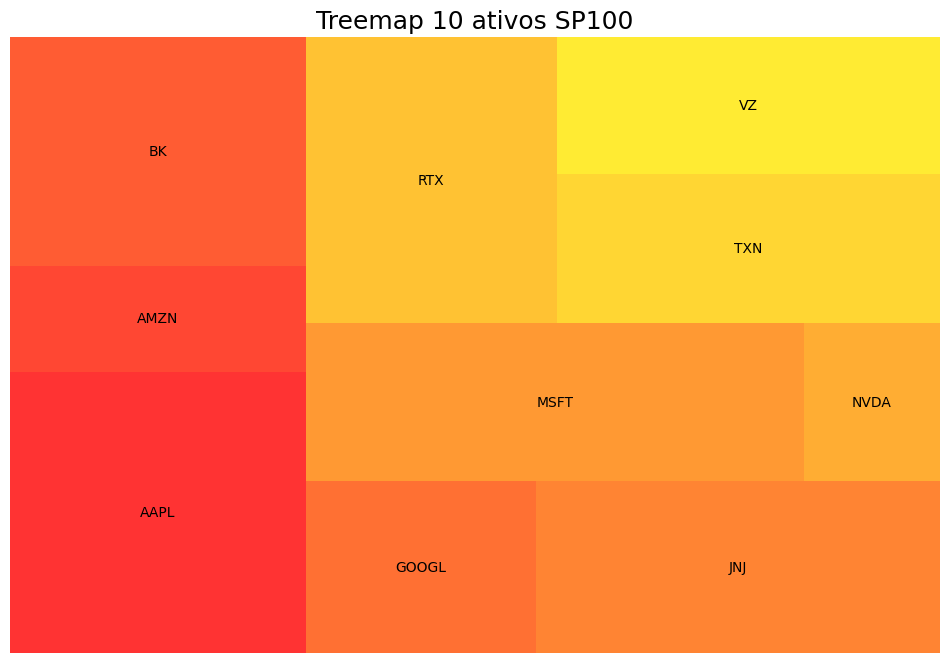

In [44]:
stocks = {
    "AAPL": 0.1453,
    "AMZN": 0.0545,
    "BK": 0.1184,
    "GOOGL": 0.0690,
    "JNJ": 0.1210,
    "MSFT": 0.1373,
    "NVDA": 0.0375,
    "RTX": 0.1255,
    "TXN": 0.0999,
    "VZ": 0.0917,
}

# Preparar dados
labels = list(stocks.keys())
values = list(stocks.values())

# Gerar cores com gradiente de outono
colors = plt.cm.autumn([i / len(values) for i in range(len(values))])

# Criar o treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=values, label=labels, alpha=0.8, color=colors)
plt.title("Treemap 10 ativos SP100", fontsize=18)
plt.axis('off')
plt.show()